# Used Car Price Prediction Using XGBRegressor

### Objective:
To develop a predictive model using Multiple Linear Regression that accurately estimates the resale price of used cars based on various features such as brand, model, year of manufacture, mileage, engine specifications, fuel type, transmission type, and other relevant attributes.

### Background:
The used car market is vast and dynamic, with car prices influenced by multiple factors. Buyers and sellers often face difficulty in determining a fair market value for a used car due to variability in car conditions, brands, and specifications. A data-driven approach can assist in setting more consistent and objective pricing.

### Scope:
This project will use a dataset containing 2059 entries with 20 features, including both numerical and categorical variables. The model will be trained to learn the relationships between these features and the car’s selling price.

### Goals:
1. Clean and preprocess the dataset (handle missing values, encoding, unit conversions).
2. Perform exploratory data analysis to understand feature relationships.
3. Detect and address multicollinearity among independent variables.
4. Build and evaluate a Multiple Linear Regression model to predict car prices.
5. Assess the model’s performance using appropriate metrics such as R², MAE, and RMSE.

### Expected Outcome:
A linear regression-based model capable of predicting the price of a used car with reasonable accuracy, which can serve as a baseline for more complex models in the future (e.g., Random Forest, Gradient Boosting).

## Libraries and Modules Used (IC)

In [4]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

## Step 1: Load and Inspect the Dataset

### 1.1 Loading Data to Jupyter

In [7]:
df = pd.read_csv("C:/Users/itsrh/Downloads/archive/car details v4.csv")

### 1.2 Seeing First Five Entries

In [9]:
df.head()

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
0,Honda,Amaze 1.2 VX i-VTEC,505000,2017,87150,Petrol,Manual,Pune,Grey,First,Corporate,1198 cc,87 bhp @ 6000 rpm,109 Nm @ 4500 rpm,FWD,3990.0,1680.0,1505.0,5.0,35.0
1,Maruti Suzuki,Swift DZire VDI,450000,2014,75000,Diesel,Manual,Ludhiana,White,Second,Individual,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,FWD,3995.0,1695.0,1555.0,5.0,42.0
2,Hyundai,i10 Magna 1.2 Kappa2,220000,2011,67000,Petrol,Manual,Lucknow,Maroon,First,Individual,1197 cc,79 bhp @ 6000 rpm,112.7619 Nm @ 4000 rpm,FWD,3585.0,1595.0,1550.0,5.0,35.0
3,Toyota,Glanza G,799000,2019,37500,Petrol,Manual,Mangalore,Red,First,Individual,1197 cc,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,FWD,3995.0,1745.0,1510.0,5.0,37.0
4,Toyota,Innova 2.4 VX 7 STR [2016-2020],1950000,2018,69000,Diesel,Manual,Mumbai,Grey,First,Individual,2393 cc,148 bhp @ 3400 rpm,343 Nm @ 1400 rpm,RWD,4735.0,1830.0,1795.0,7.0,55.0


### 1.3 Checking Dataset Size

In [11]:
df.shape

(2059, 20)

### 1.4 Checking Data Info

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Make                2059 non-null   object 
 1   Model               2059 non-null   object 
 2   Price               2059 non-null   int64  
 3   Year                2059 non-null   int64  
 4   Kilometer           2059 non-null   int64  
 5   Fuel Type           2059 non-null   object 
 6   Transmission        2059 non-null   object 
 7   Location            2059 non-null   object 
 8   Color               2059 non-null   object 
 9   Owner               2059 non-null   object 
 10  Seller Type         2059 non-null   object 
 11  Engine              1979 non-null   object 
 12  Max Power           1979 non-null   object 
 13  Max Torque          1979 non-null   object 
 14  Drivetrain          1923 non-null   object 
 15  Length              1995 non-null   float64
 16  Width 

## Step 2: Cleaning Data Set
There is an unusual discrepancy in the dtype column the columns which should be in the number format (engine, max power, and max torque) are also in the object type. This means we need to clean the data before moving any further.

### 2.1 Convert 'Engine' Column to float

In [16]:
df['Engine'] = df['Engine'].str.replace(' cc','',regex = False)
df['Engine'] = pd.to_numeric(df['Engine'],errors = 'coerce')

### 2.2 Cleaning Max Power and Max Torque. 
(We will ignore RPM for these metrics.)

In [18]:
def extract_first_number(value): # Function to extract the first number from a given string
    try:
        return float(re.findall(r'\d+\.?\d*',str(value))[0]) # Using regex to find all numbers and extracting first
    except:
        return np.nan # Return NaN in case of missing values

df['Max Power'] = df['Max Power'].apply(extract_first_number)
df['Max Torque'] = df['Max Torque'].apply(extract_first_number)

### 2.3 Converting Seating Capacity to Object
We want to treat seating capacity as categorical variable

In [20]:
df['Seating Capacity'] = df['Seating Capacity'].astype('object')

## Step 3. Priliminary EDA
Now that our dataset is clean, we will use Exploratory Data Analysis (EDA) before handling missing values to understand the structure, quality, and issues in the dataset.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Make                2059 non-null   object 
 1   Model               2059 non-null   object 
 2   Price               2059 non-null   int64  
 3   Year                2059 non-null   int64  
 4   Kilometer           2059 non-null   int64  
 5   Fuel Type           2059 non-null   object 
 6   Transmission        2059 non-null   object 
 7   Location            2059 non-null   object 
 8   Color               2059 non-null   object 
 9   Owner               2059 non-null   object 
 10  Seller Type         2059 non-null   object 
 11  Engine              1979 non-null   float64
 12  Max Power           1979 non-null   float64
 13  Max Torque          1979 non-null   float64
 14  Drivetrain          1923 non-null   object 
 15  Length              1995 non-null   float64
 16  Width 

### 3.1 Statistical summary of numerical data in the dataset.

In [24]:
df.describe().T  # T for transpose. We can use include='all' to get a summary for all data, but it is not very useful

,count,mean,std,min,25%,50%,75%,max
Price,2059.0,1.702992e+06,2.419881e+06,49000.0,484999.00,825000.0,1925000.0,35000000.0
Year,2059.0,2.016425e+03,3.363564e+00,1988.0,2014.00,2017.0,2019.0,2022.0
Kilometer,2059.0,5.422471e+04,5.736172e+04,0.0,29000.00,50000.0,72000.0,2000000.0
Engine,1979.0,1.692576e+03,6.437363e+02,624.0,1197.00,1498.0,1995.0,6592.0
Max Power,1979.0,1.296118e+02,6.507380e+01,35.0,83.00,116.0,171.0,660.0
Max Torque,1979.0,2.458510e+02,1.404657e+02,48.0,115.00,200.0,350.0,780.0
Length,1995.0,4.280861e+03,4.424585e+02,3099.0,3985.00,4370.0,4629.0,5569.0
Width,1995.0,1.767992e+03,1.352658e+02,1475.0,1695.00,1770.0,1831.5,2220.0
Height,1995.0,1.591735e+03,1.360740e+02,1165.0,1485.00,1545.0,1675.0,1995.0
Fuel Tank Capacity,1946.0,5.200221e+01,1.511020e+01,15.0,41.25,50.0,60.0,105.0


### 3.2 Categorical Feature Summary

In [26]:
categorical_features = df.select_dtypes(include='object').columns

def summarize_category(df, colname, target='Price'):
    count = df[colname].value_counts()
    mean = df.groupby(colname)[target].mean()
    summary = pd.DataFrame({'Count': count, 'Average Price': mean})
    return summary.sort_values(by='Count', ascending=False)

for col in categorical_features:
    print(f"\nSummary for: {col}")
    print(summarize_category(df, col, target='Price'))


Summary for: Make
               Count  Average Price
Make                               
Maruti Suzuki    440   5.348000e+05
Hyundai          349   7.232635e+05
Mercedes-Benz    171   4.384860e+06
Honda            158   6.221076e+05
Toyota           132   1.729545e+06
Audi             127   2.703134e+06
BMW              121   3.768967e+06
Mahindra         119   1.083479e+06
Tata              57   9.907368e+05
Volkswagen        50   7.074599e+05
Ford              48   1.474625e+06
Renault           43   4.695813e+05
Skoda             40   1.498225e+06
Land Rover        33   6.699333e+06
Kia               23   1.569913e+06
Jeep              18   1.956889e+06
MG                17   2.024118e+06
Jaguar            17   3.564647e+06
Nissan            16   4.821875e+05
Volvo             16   3.090875e+06
Porsche           15   8.342667e+06
MINI              11   3.054909e+06
Datsun             8   2.978750e+05
Chevrolet          7   3.412856e+05
Lexus              6   4.125000e+06
Mitsubish

As we can see from the above table, there are some categories with very few frequencies, especially in the model column, which has more than 1000 unique categories. This will cause problems during EDA and one-hot encoding, and will exponentially increase computation time. We will deal with these problems during feature engineering.

### 3.3 Target Variable Distribution

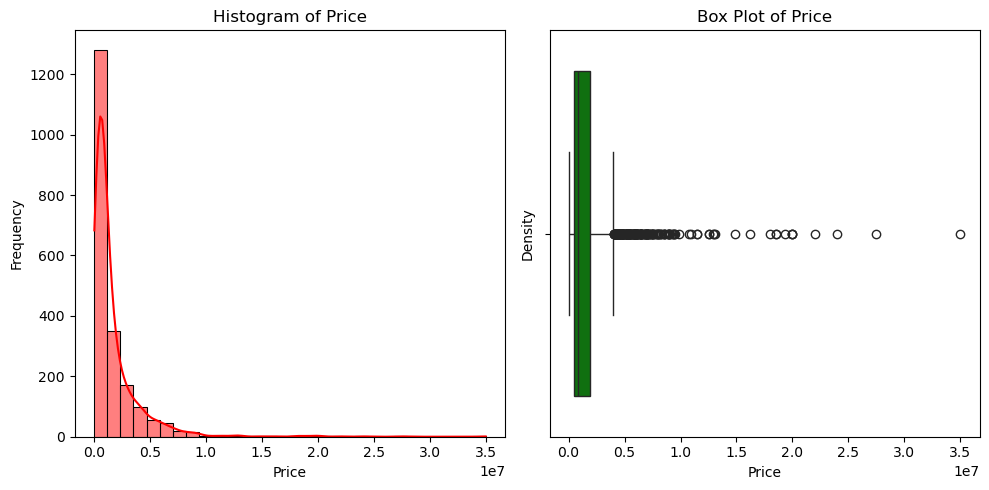

In [29]:
# set price as target
target = 'Price'
# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Histogram
sns.histplot(data=df, x=target, bins=30, kde=True, ax=axes[0], color='red')
axes[0].set_title('Histogram of Price')
axes[0].set_xlabel(target)
axes[0].set_ylabel('Frequency')

# Box Plot
sns.boxplot(data=df, x=target, fill=True, ax=axes[1], color='green')
axes[1].set_title('Box Plot of Price')
axes[1].set_xlabel(target)
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

### 3.4 Distribution of Numerical Features

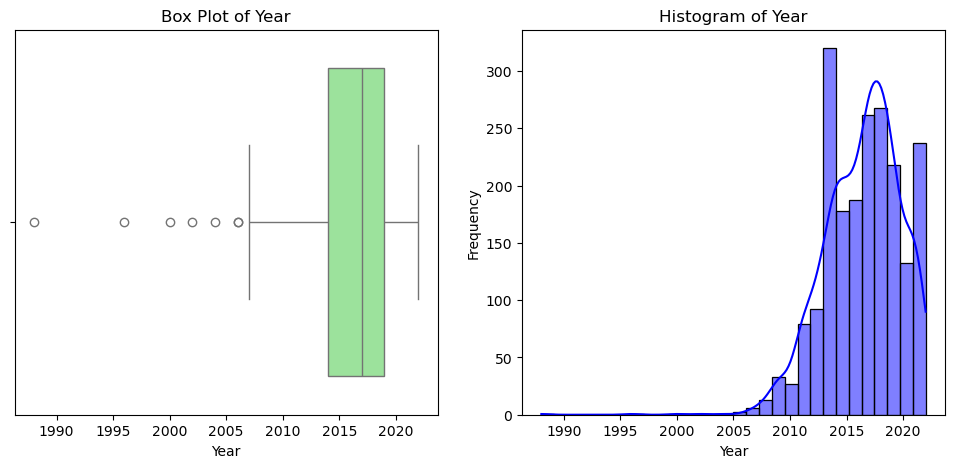

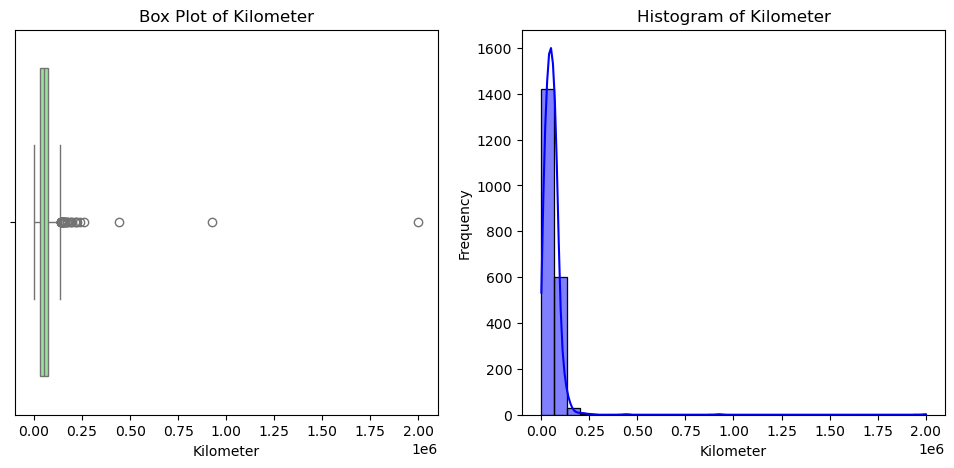

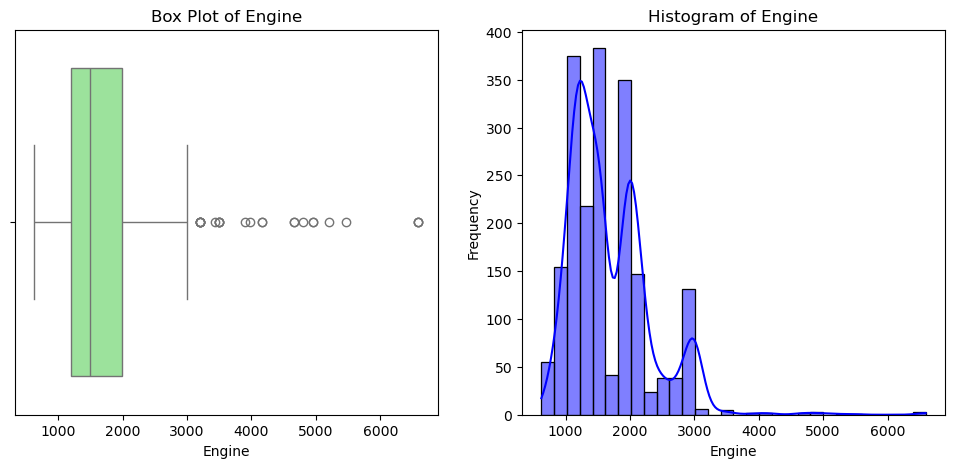

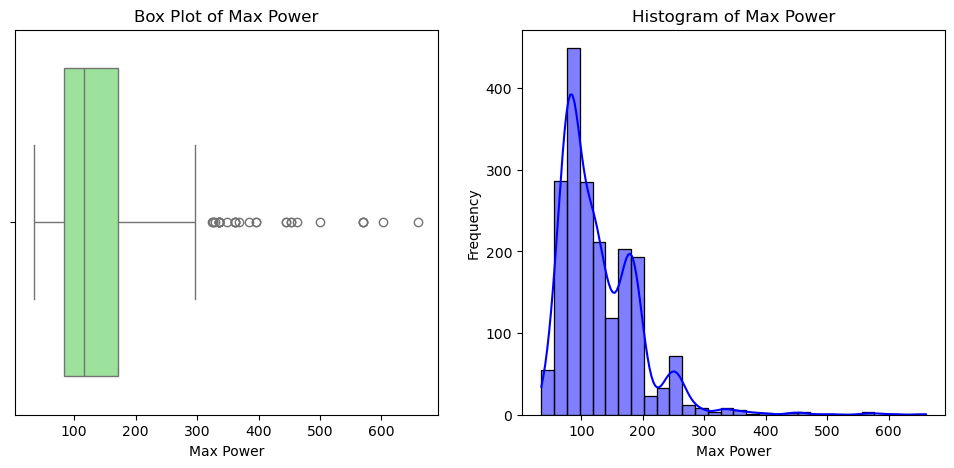

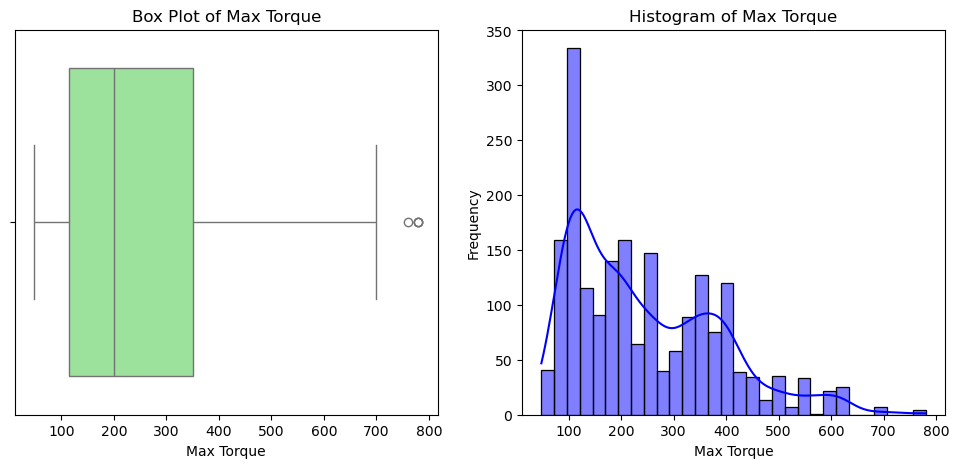

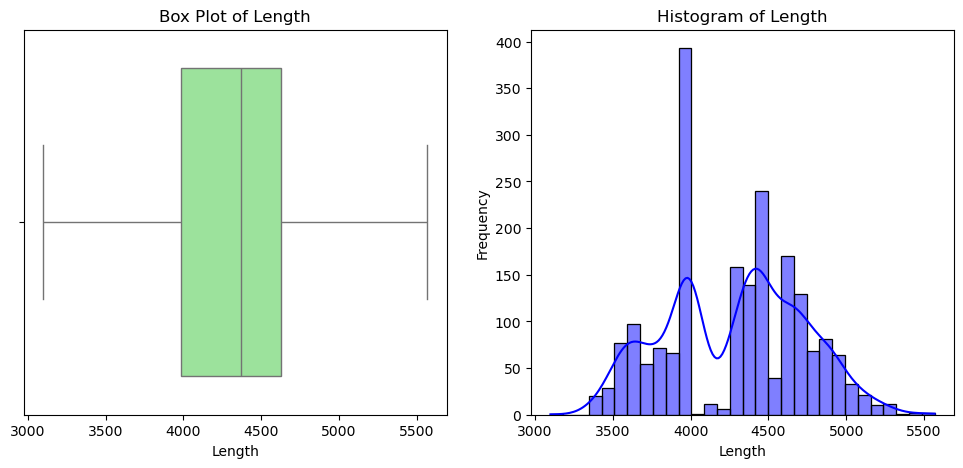

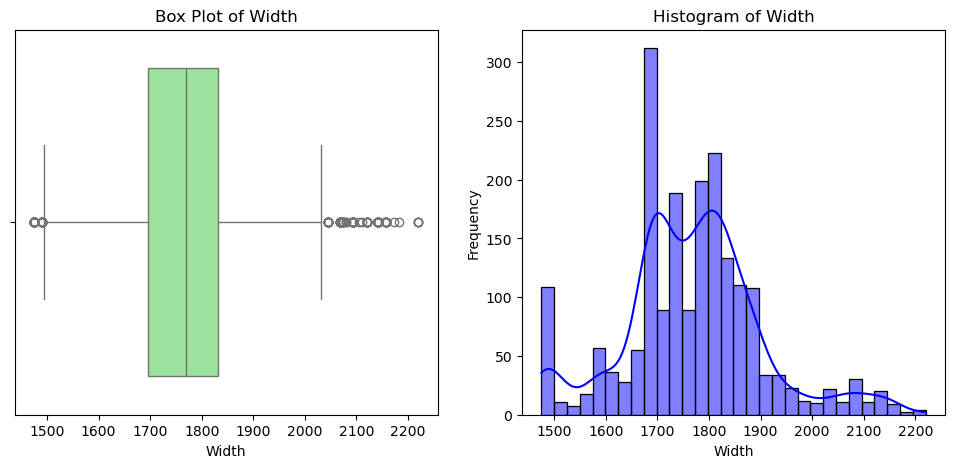

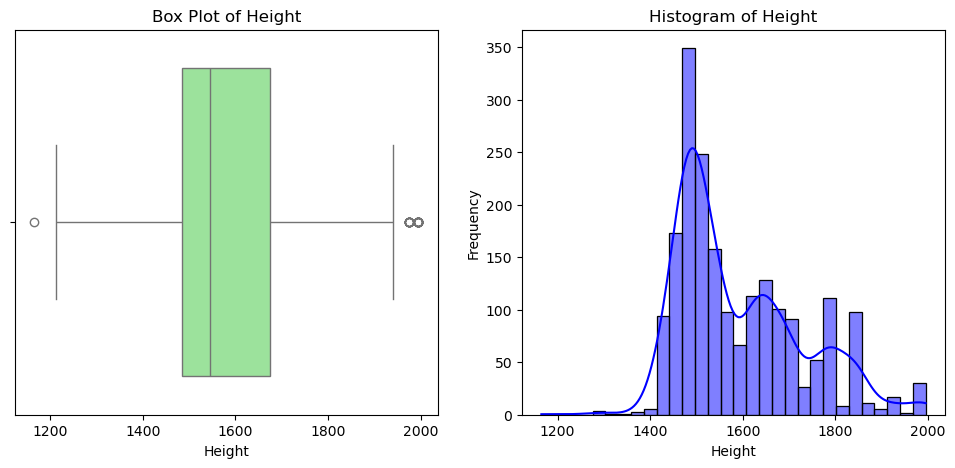

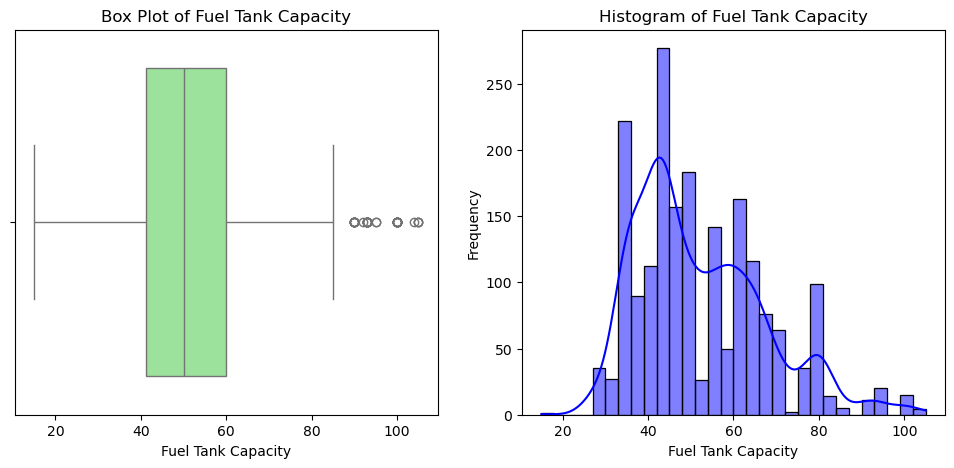

In [31]:
# Select only numerical features
numerical_features = df.select_dtypes(include='number').columns
numerical_features = numerical_features.drop('Price')

for i, col in enumerate(numerical_features, 1):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # Histogram
    sns.histplot(data=df, x=col, bins=30, kde=True, ax=axes[1], color='blue')
    axes[1].set_title(f'Histogram of {col}')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Frequency')
    
    # Box Plot
    sns.boxplot(data=df, x=col, ax=axes[0], color='lightgreen')
    axes[0].set_title(f'Box Plot of {col}')
    axes[0].set_xlabel(col)
    
plt.show()

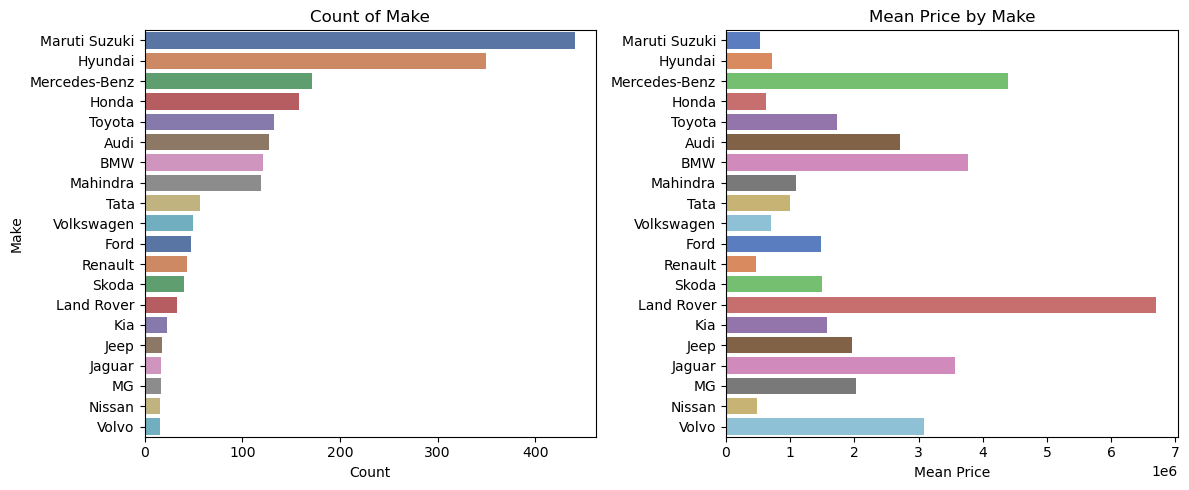

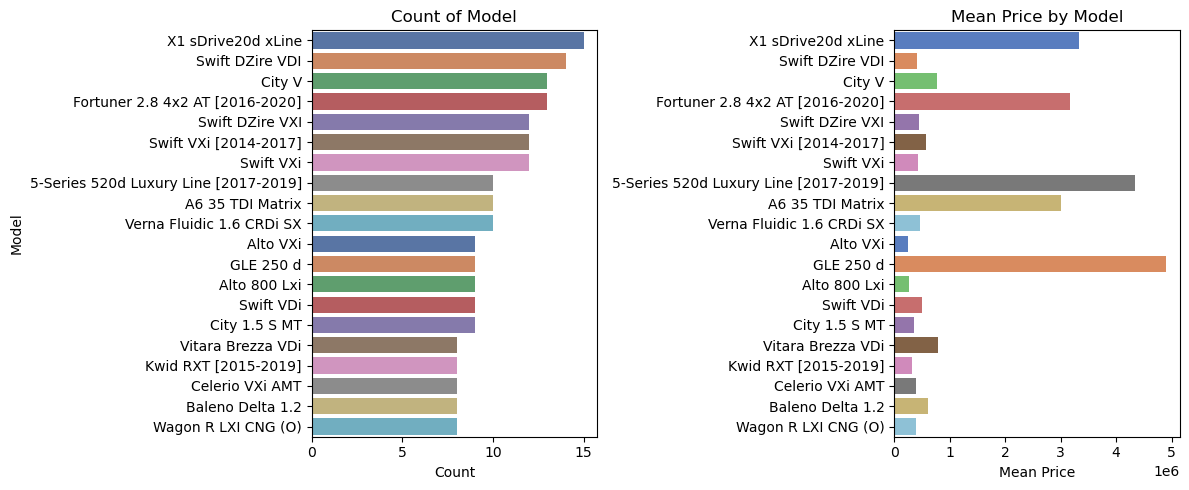

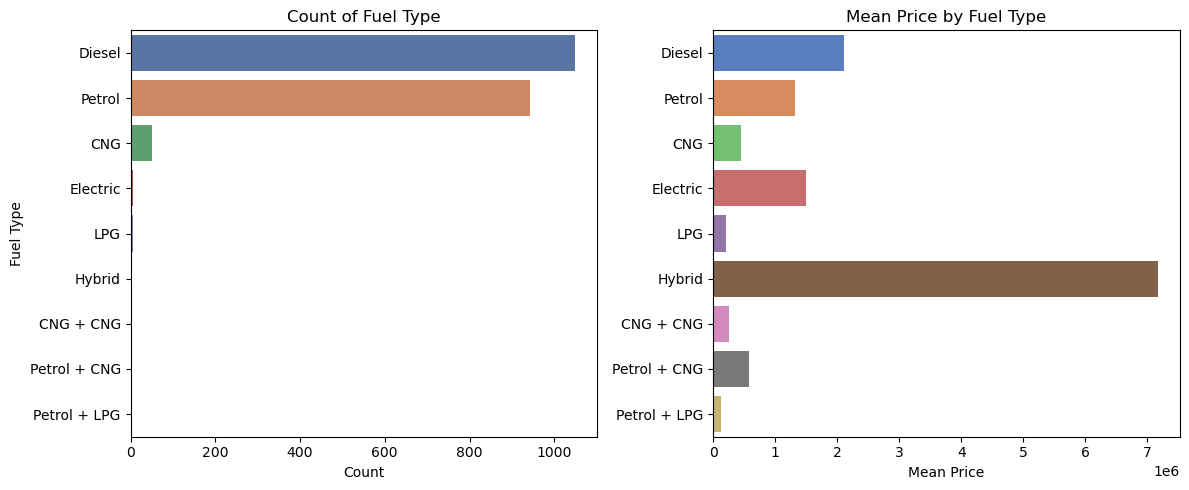

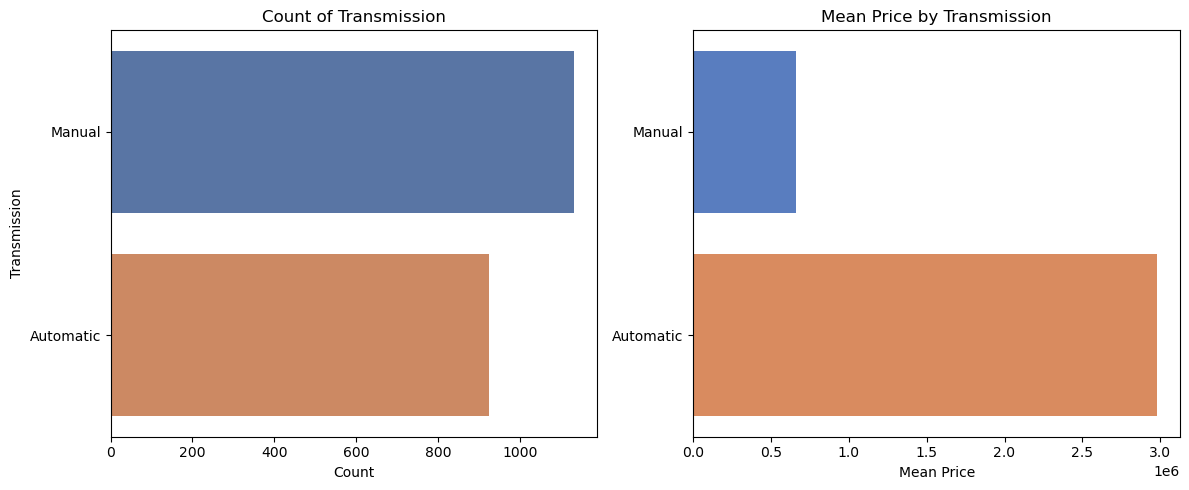

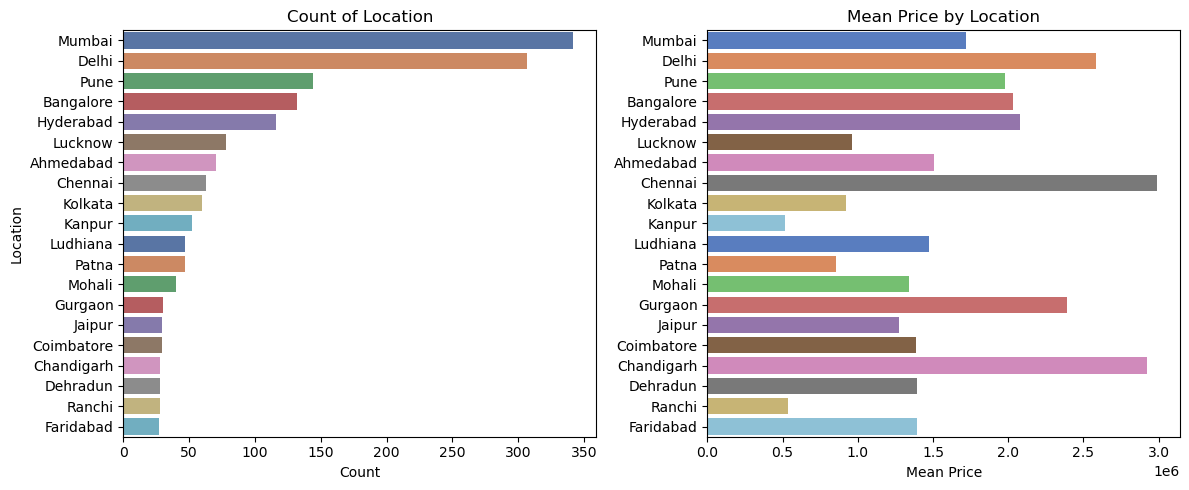

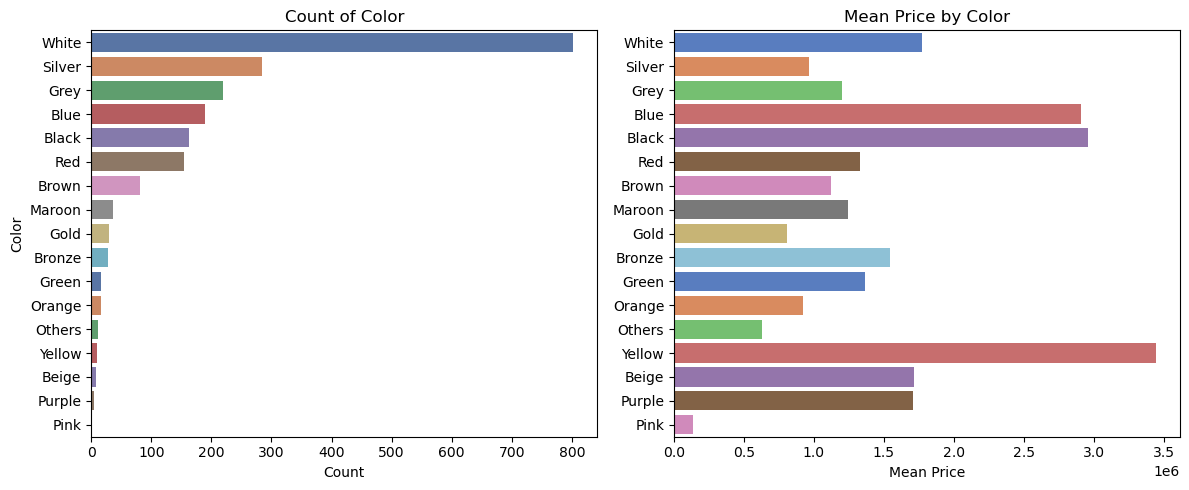

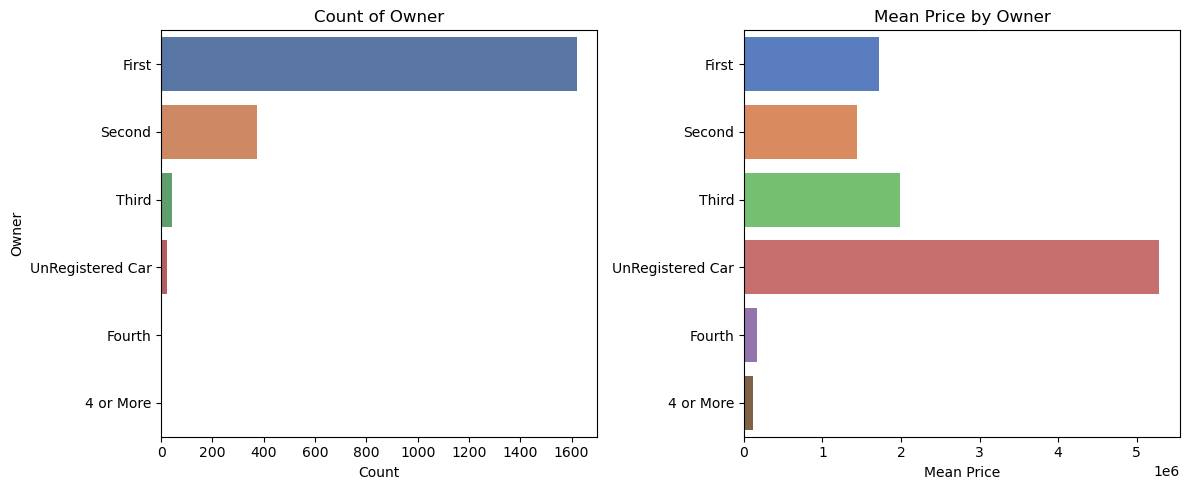

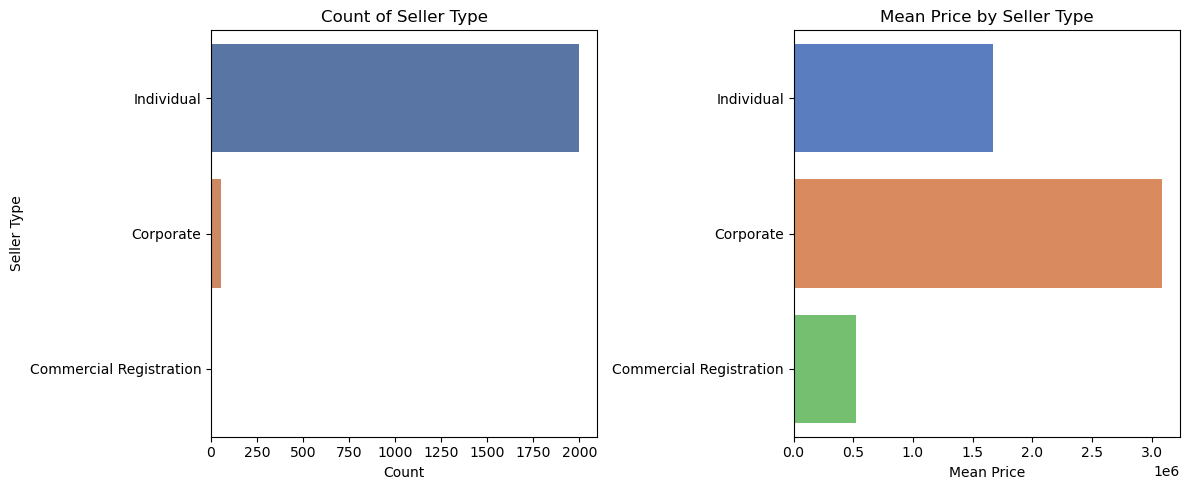

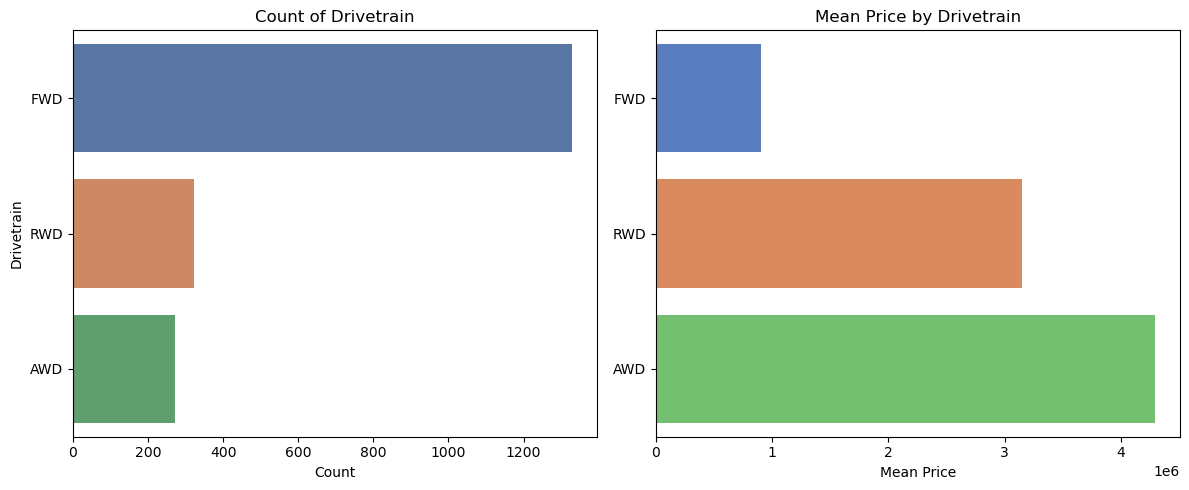

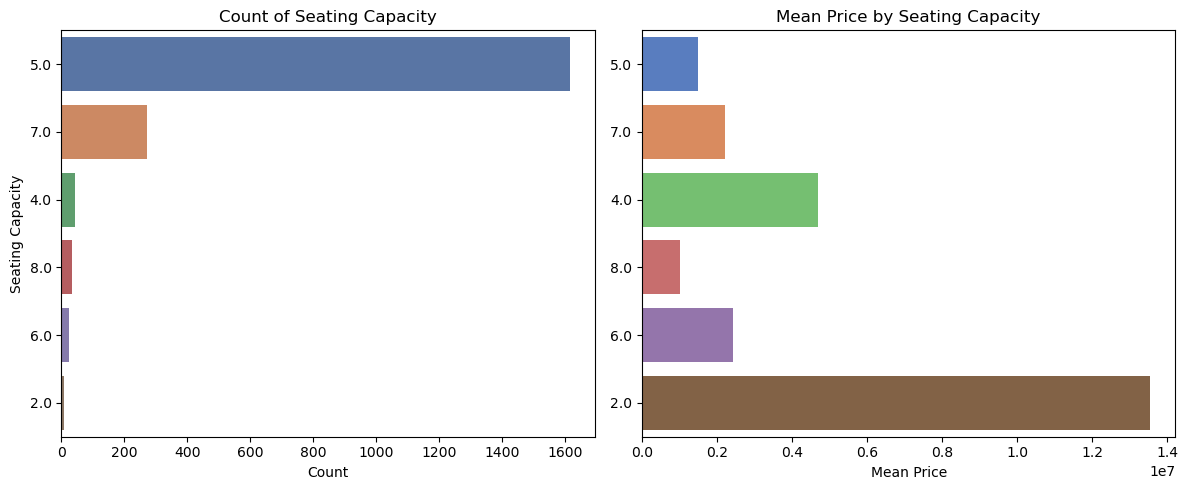

In [32]:
 for col in categorical_features:
        # Prepare data
        count = df[col].value_counts().head(20)
        mean_target = df.groupby(col)[target].mean().loc[count.index]

        # Create subplot
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Barplot: count
        sns.barplot(x=count.values, y=count.index.astype(str), ax=axes[0], palette='deep')
        axes[0].set_title(f'Count of {col}')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel(col)

        # Barplot: mean target
        sns.barplot(x=mean_target.values, y=mean_target.index.astype(str), ax=axes[1], palette='muted')
        axes[1].set_title(f'Mean {target} by {col}')
        axes[1].set_xlabel(f'Mean {target}')
        axes[1].set_ylabel('')

        plt.tight_layout()
        plt.show()

### 3.5 Scatter plot for numerical features

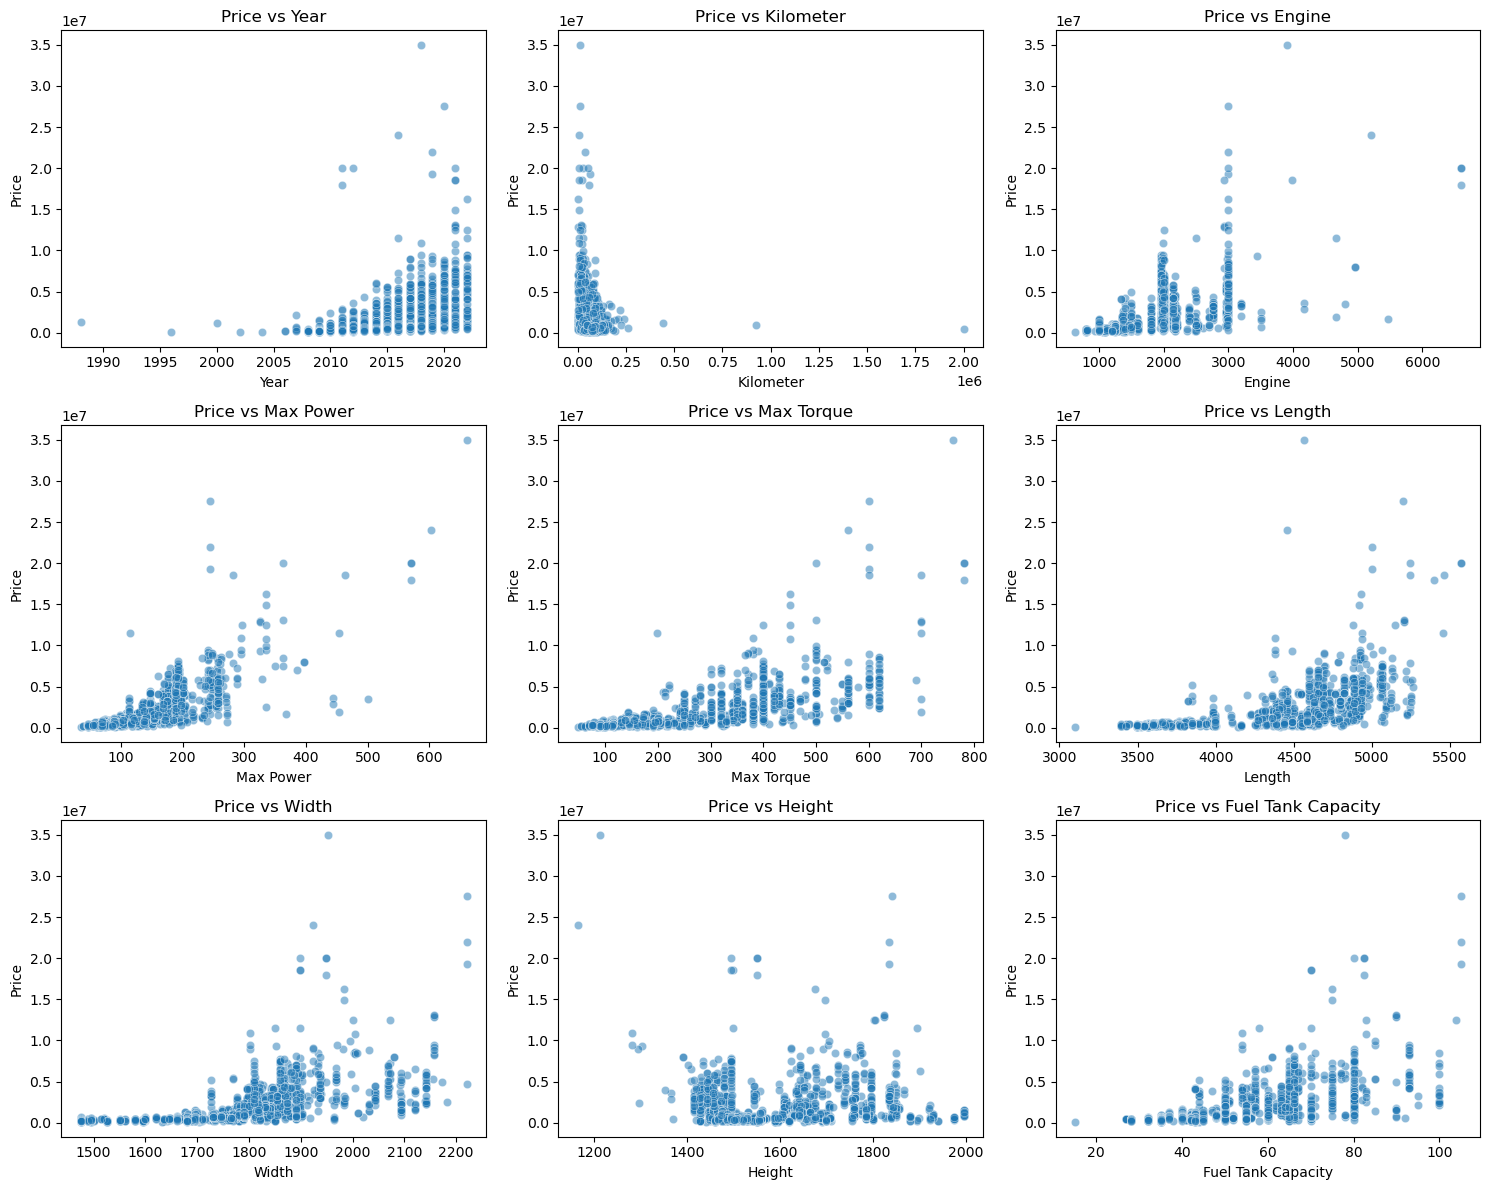

In [34]:
# Set up layout: 3 plots per row
n_cols = 3
n_rows = (len(numerical_features) + n_cols - 1) // n_cols  # ceiling division

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for idx, col in enumerate(numerical_features, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.scatterplot(x=df[col], y=df[target], alpha=0.5)
    plt.title(f'{target} vs {col}')
    plt.xlabel(col)
    plt.ylabel(target)
plt.tight_layout()
plt.show()

From the scatter plots of numerical features against price, we can observe that variables like engine size, max power, torque, length, width, and fuel tank capacity show a generally positive relationship with price, indicating that larger or more powerful vehicles tend to be more expensive. Kilometers driven shows a strong negative correlation with price, which makes sense as more used cars are typically less valuable; however, the relationship may be non-linear and could benefit from a log transformation to stabilize variance. The year of manufacture shows a loose positive trend with price, though it may be more meaningful to convert it into car age for analysis. On the other hand, features like height and seating capacity do not show a clear trend, suggesting a weak or non-linear relationship.

## Step 4 Handling Missing Values

### 4.1 Checking number of missing values.

In [38]:
df.isnull().sum()

Make                    0
Model                   0
Price                   0
Year                    0
Kilometer               0
Fuel Type               0
Transmission            0
Location                0
Color                   0
Owner                   0
Seller Type             0
Engine                 80
Max Power              80
Max Torque             80
Drivetrain            136
Length                 64
Width                  64
Height                 64
Seating Capacity       64
Fuel Tank Capacity    113
dtype: int64

## 4.2 Visualize missingness to check if there is any pattern to missing values.

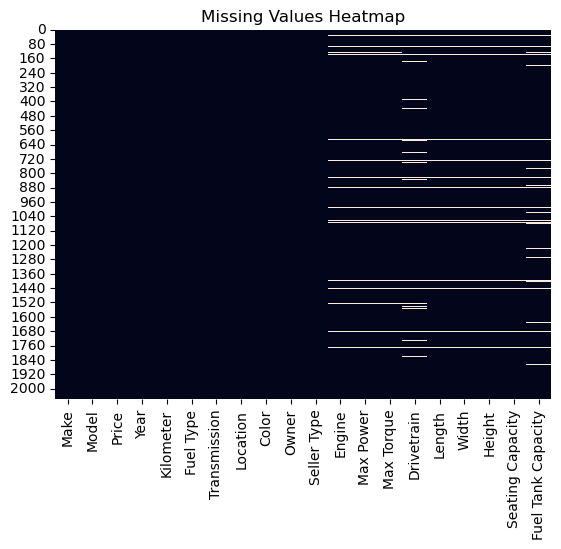

In [40]:
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

The above heat map shows that most missing values are from the drivetrain and the fuel tank capacity. Also same entries have more than one missing value. Now, we will examine whether the distribution of price changes when a feature is missing.

### 4.3 Checking the difference between distribution of the target variable for missing data, and overall data. 

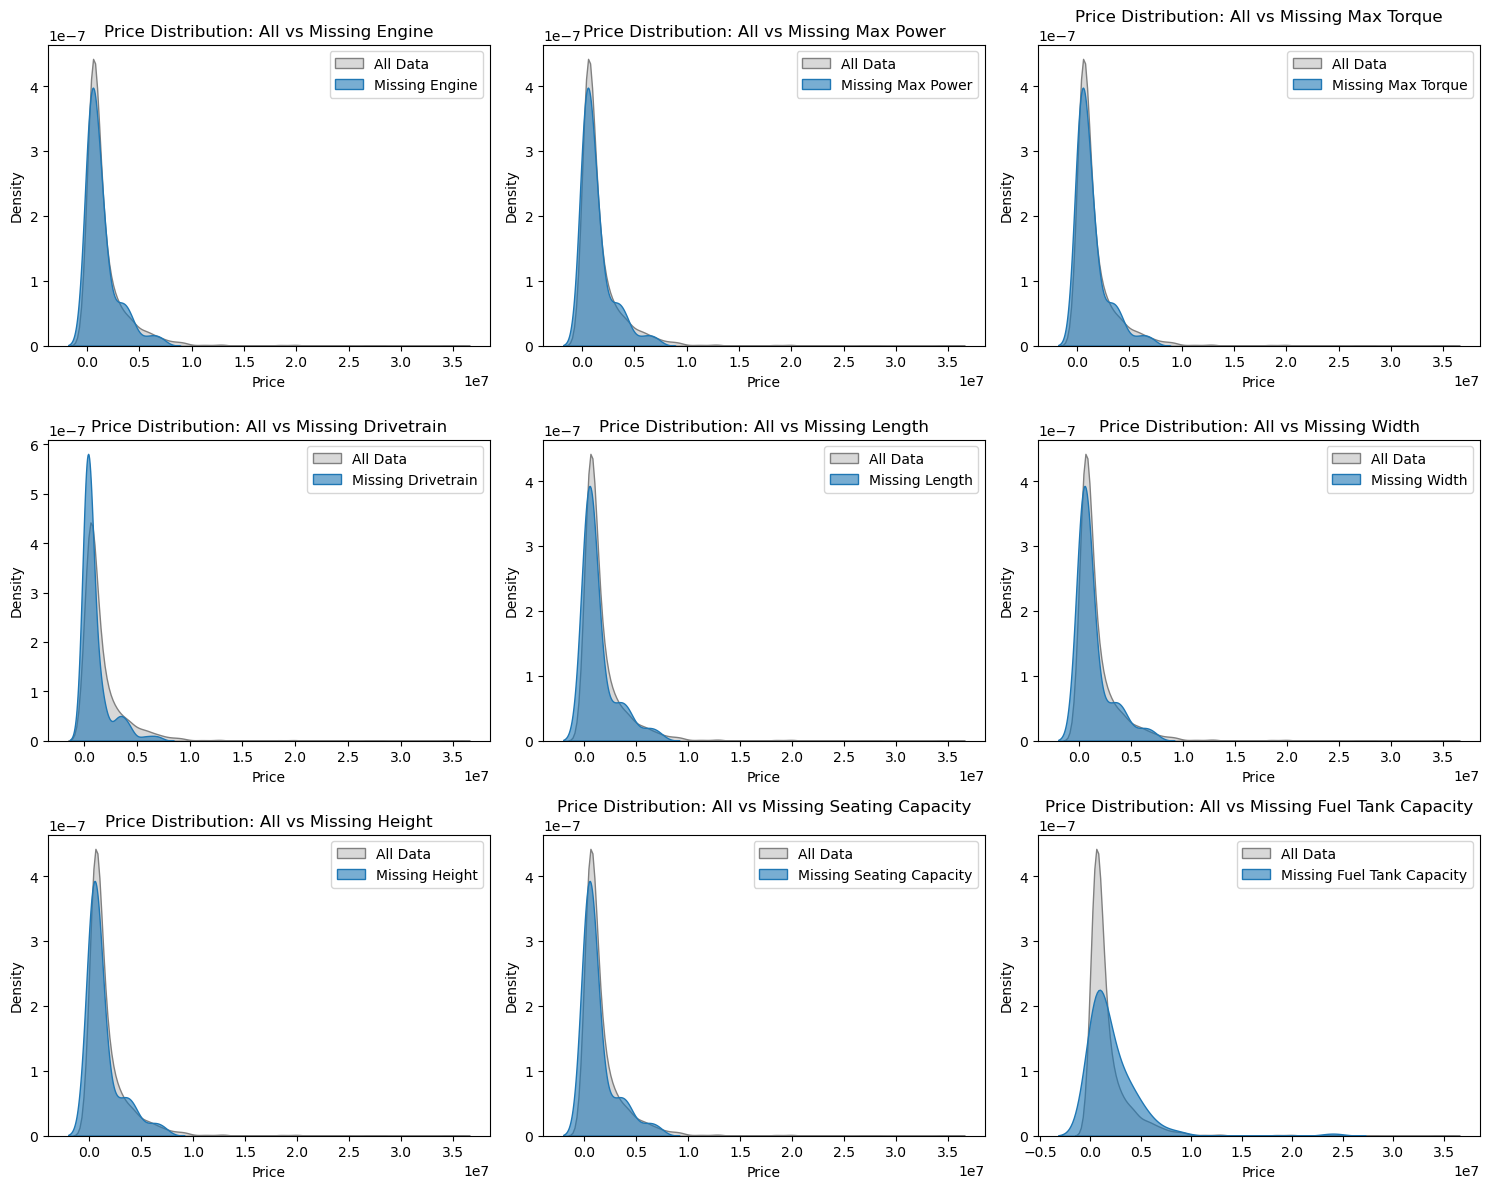

In [43]:
# Columns with missing values
missing_cols = df.columns[df.isnull().any()]

# Set up layout: 3 plots per row
n_cols = 3
n_rows = (len(missing_cols) + n_cols - 1) // n_cols  # ceiling division
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(missing_cols, 1):
    plt.subplot(n_rows, n_cols, i)

    # Full target distribution
    sns.kdeplot(df[target], label='All Data', fill=True, alpha=0.3, color='gray')

    # Target distribution where col is missing
    sns.kdeplot(df[df[col].isnull()][target], label=f'Missing {col}', fill=True, alpha=0.6)

    plt.title(f'{target} Distribution: All vs Missing {col}')
    plt.xlabel(target)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

All features except the fuel tank capacity and drivetrain show mostly similar distribution of price for missing values and all data, suggesting MCAR or Weak MAR. Therefore, we can safely impute missing values or drop these features without worry. For fuel tank capacity and drivetrain, we will use other methods, depending on further analysis.

As a thumb rule, we can safely impute missing values with the mean, mode, or median when the missing data is less than 5% of the data. For 5% to 20 %, we have to be careful when imputing, and should consider dropping if the feature is less important. For more than 20% missing values, it is safer to drop the feature, unless it is a very important feature.

### 4.4 Imputing Engine, Max Power and Max Torque.

Since the distribution of these features is right-skewed, and a few large values pull up the mean, we will impute missing values by the median.

In [46]:
for col in ['Engine', 'Max Power', 'Max Torque']:
    median_val = df[col].median()
    df[col] = df[col].fillna(float(round(median_val)))

### 4.5 Imputing Length, Height and Width

While the graph of Height is right-skewed, the same cannot be said for Length and Width, which have irregular graphs. Hence, we will impute these missing values using the median grouped by Make.

In [48]:
# List of columns to impute
columns_to_impute = ['Length', 'Width', 'Height']

# Loop through each column
for column in columns_to_impute:
    
    # Group by 'Make' and compute the median per group
    median_per_make = df.groupby('Make')[column].median().round().astype(float)
    
    # Use fillna with map to apply the median of each Make
    df[column] = df[column].fillna(df['Make'].map(median_per_make))

### 4.5 Imputing Seating Capacity
We are treating sitting capacity as a categorical value. Hence, we will impute these missing values using the mode grouped by Make.

In [50]:
def get_first_mode(series):
    modes = series.mode()
    if not modes.empty:
        return modes[0]
    else:
        return np.nan
# Group by 'Make' and compute the median per group
mode_per_make = df.groupby('Make')['Seating Capacity'].apply(get_first_mode)

# Use fillna with map to apply the mode of each Make
df['Seating Capacity'] = df['Seating Capacity'].fillna(df['Make'].map(mode_per_make))

### 4.6 Imputing Drivetrain
Drive train is categorical data, and missing values are more than 5% of all data. Furthermore, the distribution of the target variable with missing drivetrain data is not similar to the distribution of the overall target variable. We cannot consider it missing at random. Hence, we will consider missingness as another feature.

In [52]:
df['Drivetrain'] = df['Drivetrain'].fillna('Missing')

### 4.6 Imputing Fuel Tank Capacity
Fuel Tank Capacity is numerical data, and missing values are more than 5% of all data. Furthermore, the distribution of the target variable with missing drivetrain data is not similar to the distribution of the overall target variable. We cannot consider it missing at random. Hence, we will impute missing values with prouped by make median, and add another flag feature to denote missing fuel_tank capacity.

In [54]:
df['Fuel_Tank_Capacity_Missing'] = df['Fuel Tank Capacity'].isna().astype(int)
median_capacity = df.groupby('Make')['Fuel Tank Capacity'].median().round().astype(float)
df['Fuel Tank Capacity'] = df['Fuel Tank Capacity'].fillna(df['Make'].map(median_capacity))

### 4.7 Rechecking Missing Values

In [56]:
df.isnull().sum()

Make                          0
Model                         0
Price                         0
Year                          0
Kilometer                     0
Fuel Type                     0
Transmission                  0
Location                      0
Color                         0
Owner                         0
Seller Type                   0
Engine                        0
Max Power                     0
Max Torque                    0
Drivetrain                    0
Length                        0
Width                         0
Height                        0
Seating Capacity              0
Fuel Tank Capacity            1
Fuel_Tank_Capacity_Missing    0
dtype: int64

### 4.8 Distribution of Numerical Features After Handling Missing Values

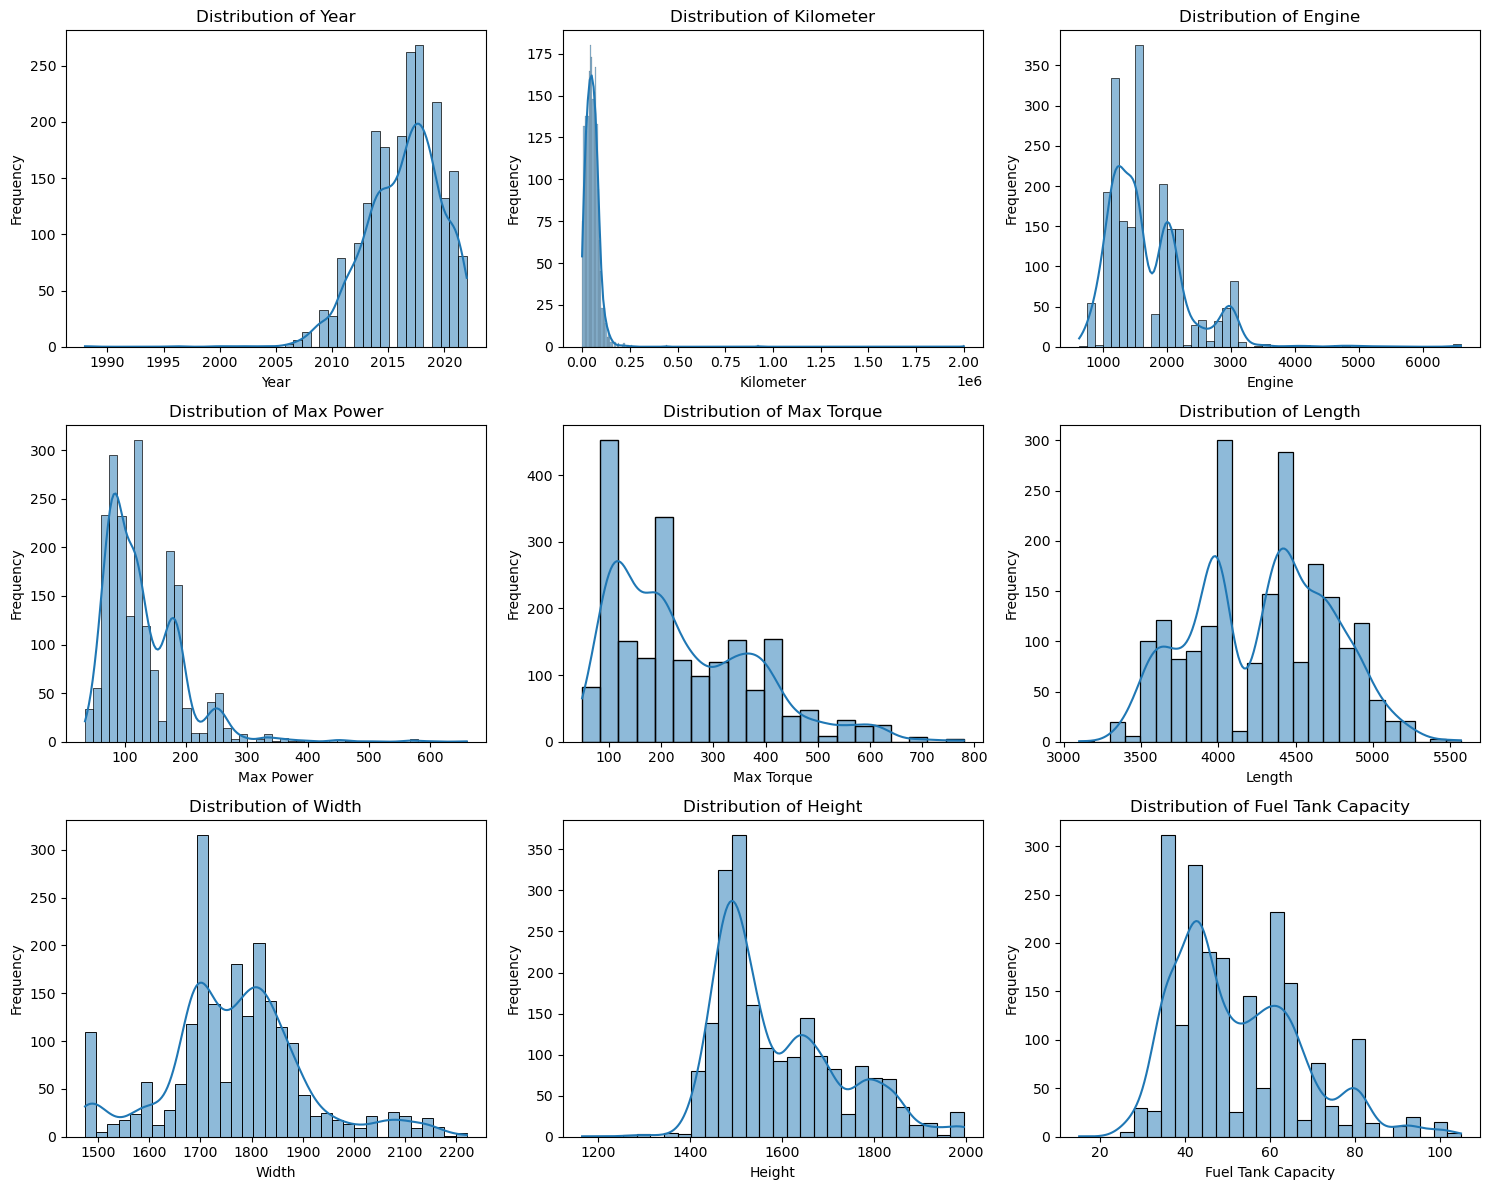

In [58]:
n_cols = 3
n_rows = (len(numerical_features) + n_cols - 1) // n_cols

# Create subplots
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(numerical_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

There is no significant change in distribution.

## Step 5: Featuring Engneering (Categorical Variable)

### 5.1 Clubbing Rare Makes
We're identifying all car makes that appear in less than 1% of the dataset and categorising them into Rare_Low, Rare_Mid, and Rare_High based on which quartile their median price falls into (using the overall Price distribution). 

In [62]:
# Step 1: Compute quartiles of overall price
q1 = df['Price'].quantile(0.25)
q2 = df['Price'].quantile(0.50)
q3 = df['Price'].quantile(0.75)

# Step 2: Identify rare makes (frequency less than 1% of total)
threshold = 0.01 * len(df)
rare_makes = df['Make'].value_counts()[df['Make'].value_counts() < threshold].index

# Step 3: Compute median price per make
make_medians = df.groupby('Make')['Price'].median()

# Step 4: Map rare makes to Rare_Low, Rare_Mid, or Rare_High
rare_make_mapping = {}
for make in rare_makes:
    price = make_medians[make]
    if price <= q1:
        rare_make_mapping[make] = 'Rare_Low'
    elif price <= q3:
        rare_make_mapping[make] = 'Rare_Mid'
    else:
        rare_make_mapping[make] = 'Rare_High'

# Step 5: Replace rare makes in the dataframe
df['Make'] = df['Make'].replace(rare_make_mapping)


### 5.2 Reducing Cardinality of Model
To reduce the high cardinality of the Model feature, we will extract the first word from each model name, assuming it represents the car’s series or variant line. This grouping aims to significantly reduce the number of unique model categories while retaining meaningful distinctions. If the reduction is not substantial, we will drop the Model feature to prevent overfitting and simplify the model.

In [64]:
# Step 1: Extract the first word from the model
df['Model_Group'] = df['Model'].str.split().str[0]

# Step 2: Check how many unique values remain
print("Unique models before:", df['Model'].nunique())
print("Unique models after:", df['Model_Group'].nunique())

Unique models before: 1050
Unique models after: 196


While the Reduction in Model categories is substantial, 196 is still too many. We have tried other options, and none have worked, so we will drop this feature.

In [66]:
df.drop(columns=['Model','Model_Group'], inplace=True)

### 5.3 Clubbing Rare Fuel Type
We're identifying all fuel type makes that appear in less than 50 of the dataset and grouping them into a new category — "Other".

In [68]:
rare_fuels = df['Fuel Type'].value_counts()[df['Fuel Type'].value_counts() < 51].index
df['Fuel Type'] = df['Fuel Type'].replace(rare_fuels, 'Other')

### 5.4 Reducing Cardinality of Location
We have 77 different Locations, which is too much; we will club cities into various tiers, as categorised by the government. 

In [70]:
# Define Tier 1 and Tier 2 city lists
tier1 = [
    'Ahmedabad', 'Bengaluru', 'Chennai', 'Delhi',
    'Hyderabad', 'Kolkata', 'Mumbai', 'Pune'
]

tier2 = [
    'Agra', 'Ajmer', 'Akola', 'Aligarh', 'Amravati', 'Amritsar', 'Anand', 'Asansol', 'Aurangabad',
    'Bareilly', 'Bardhaman', 'Belagavi', 'Berhampur', 'Bhavnagar', 'Bhiwandi', 'Bhopal',
    'Bhubaneswar', 'Bikaner', 'Bilaspur', 'Bokaro Steel City', 'Bellary', 'Chandigarh', 'Coimbatore',
    'Cuttack', 'Dahod', 'Dehradun', 'Dhule', 'Dombivli', 'Dhanbad', 'Bhilai', 'Durgapur', 'Erode',
    'Faridabad', 'Ghaziabad', 'Gorakhpur', 'Guntur', 'Gurgaon', 'Guwahati', 'Gwalior', 'Hamirpur',
    'Hubballi–Dharwad', 'Indore', 'Jabalpur', 'Jaipur', 'Jalandhar', 'Jalgaon', 'Jammu',
    'Jamshedpur', 'Jamnagar', 'Jhansi', 'Jodhpur', 'Kalaburagi', 'Kakinada', 'Kannur', 'Kanpur',
    'karimnagar', 'Karnal', 'Kochi', 'Kolhapur', 'Kollam', 'Kota', 'Kozhikode', 'Kumbakonam',
    'Kurnool', 'Ludhiana', 'Lucknow', 'Madurai', 'Mathura', 'Mangaluru', 'Meerut', 'Mohali',
    'Moradabad', 'Mysuru', 'Nagpur', 'Nanded', 'Nadiad', 'Nashik', 'Nellore', 'Noida', 'Patna',
    'Pimpri-Chinchwad', 'Puducherry', 'Purulia', 'Prayagraj', 'Raipur', 'Rajkot', 'Ranchi',
    'Rourkela', 'Ratlam', 'Raichur', 'Saharanpur', 'Salem', 'Sangli', 'Shimla', 'Siliguri',
    'Solapur', 'Srinagar', 'Surat', 'Thanjavur', 'Thiruvananthapuram', 'Thrissur',
    'Tiruchirappalli', 'Tirunelveli', 'Tiruvannamalai', 'Ujjain', 'Vijayapura', 'Vadodara',
    'Varanasi', 'Vasai-Virar', 'Vijayawada', 'Visakhapatnam', 'Vellore', 'Warangal'
]

# Create a mapping function
def map_location_to_tier(location):
    if location in tier1:
        return 'Tier 1'
    elif location in tier2:
        return 'Tier 2'
    else:
        return 'Tier 3'

# Apply the mapping to create a new column
df['City_Tier'] = df['Location'].apply(map_location_to_tier)

# Drop the original location column
df.drop('Location', axis=1, inplace=True)

### 5.5 Clubbing Rare Color Type
We're identifying all colors that appear in less than 10 of the dataset and grouping them into a new category — "Other".

In [72]:
color_counts = df['Color'].value_counts()
rare_colors = color_counts[color_counts < 20].index
df['Color'] = df['Color'].replace(rare_colors, 'Other')

### 5.6 Combining Commercial and Corporate Ownership

In [74]:
df['Seller Type'] = df['Seller Type'].replace({
    'Corporate': 'Commercial or Corporate',
    'Commercial Registration': 'Commercial or Corporate'
})

### 5.7 Droping Entries With Sitting Capacity of 2
We have only 7 entries with a seating capacity of 2.0, which is less than 0.4% of your dataset (2059 rows). These are likely two-seater vehicles (e.g., sports cars or small commercial vehicles) and may behave quite differently in terms of pricing, possibly skewing the model.

In [76]:
df = df[df['Seating Capacity'] != 2.0]

### 5.8 Replacing Year With Age

In [78]:
df['Age'] = 2025 - df['Year']
df.drop('Year', axis=1, inplace=True)

### 5.9 Clubbing Cars with more than three owners Together

In [80]:
df['Owner'] = df['Owner'].replace({'Third': '3 or More', 'Fourth': '3 or More', '4 or More': '3 or More'})

### 5.10 Analyze Categorical Variables After Modification
After modifying the categorical variable to improve the efficiency of our model, we will now perform EDA on the modified categorical variables.

In [82]:
categorical_features = df.select_dtypes(include='object').columns

def summarize_category(df, colname, target='Price'):
    count = df[colname].value_counts()
    mean = df.groupby(colname)[target].mean()
    summary = pd.DataFrame({'Count': count, 'Average Price': mean})
    return summary.sort_values(by='Count', ascending=False)

for col in categorical_features:
    print(f"\nSummary for: {col}")
    print(summarize_category(df, col, target='Price'))


Summary for: Make
               Count  Average Price
Make                               
Maruti Suzuki    440   5.348000e+05
Hyundai          349   7.232635e+05
Mercedes-Benz    170   4.396535e+06
Honda            158   6.221076e+05
Toyota           132   1.729545e+06
Audi             126   2.692841e+06
BMW              121   3.768967e+06
Mahindra         119   1.083479e+06
Rare_High         68   4.927029e+06
Tata              57   9.907368e+05
Volkswagen        50   7.074599e+05
Ford              48   1.474625e+06
Renault           43   4.695813e+05
Rare_Mid          42   1.847119e+06
Skoda             40   1.498225e+06
Land Rover        33   6.699333e+06
Rare_Low          33   3.968788e+05
Kia               23   1.569913e+06

Summary for: Fuel Type
           Count  Average Price
Fuel Type                      
Diesel      1049   2.101848e+06
Petrol       935   1.230549e+06
Other         68   8.273235e+05

Summary for: Transmission
              Count  Average Price
Transmission   

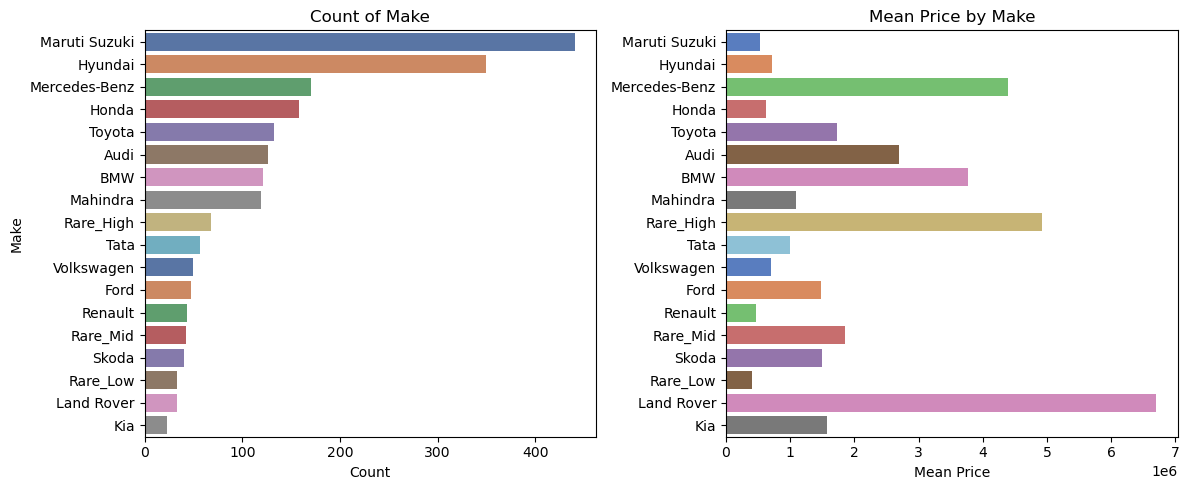

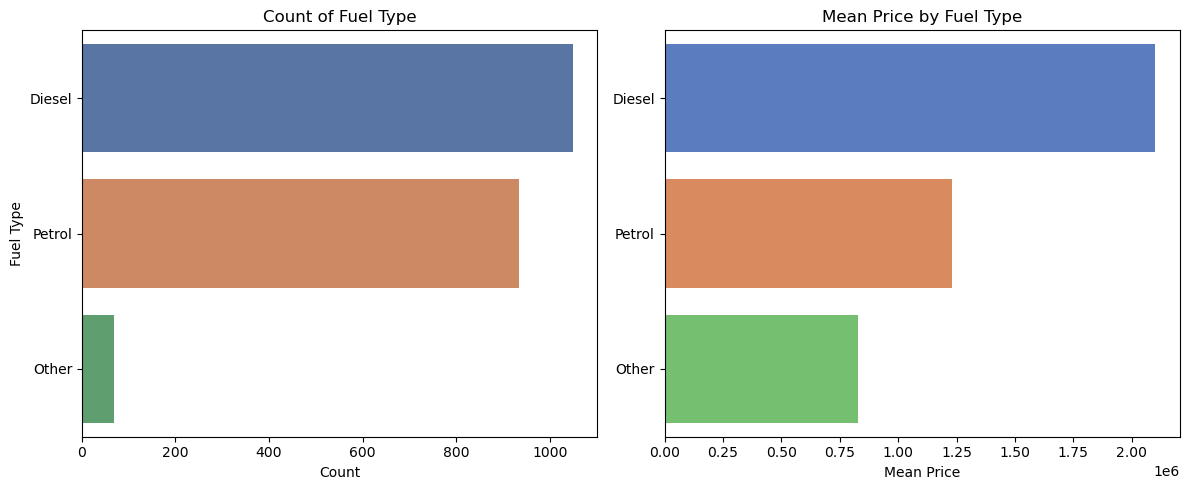

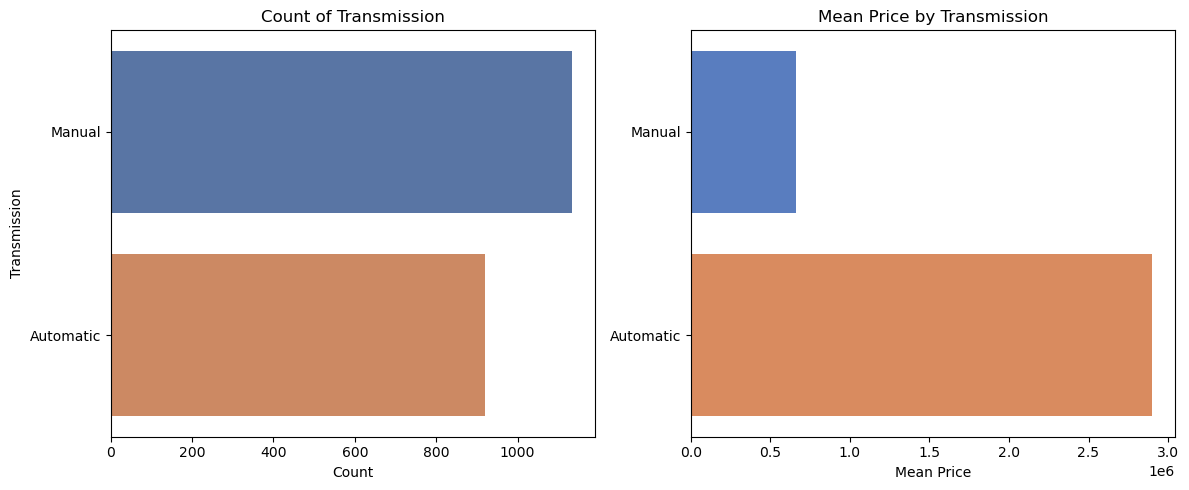

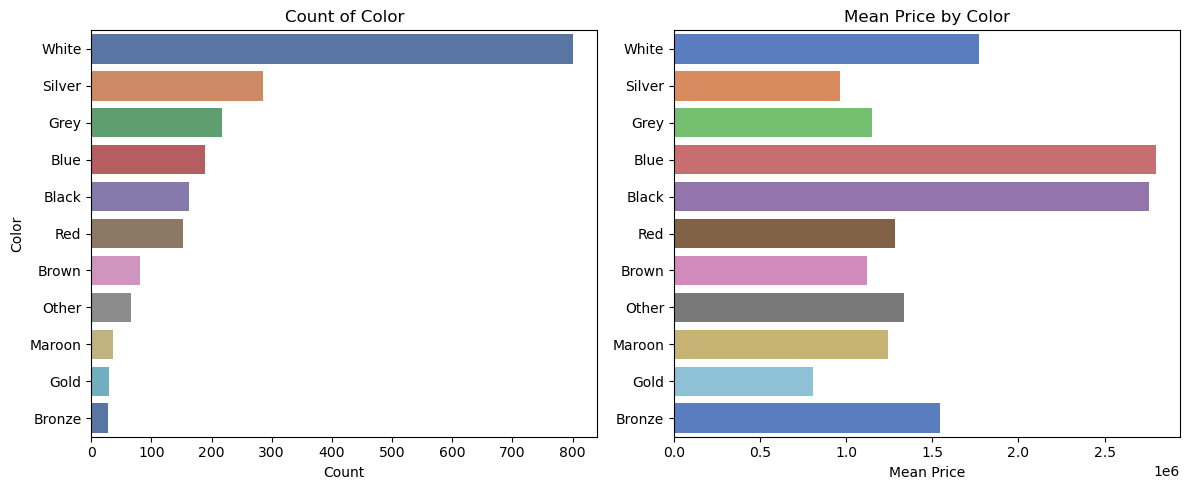

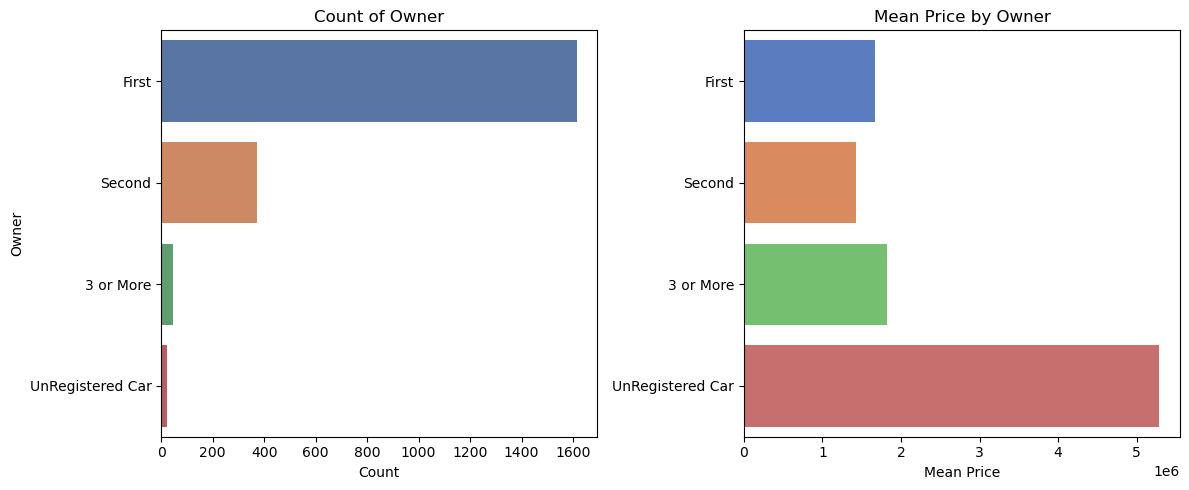

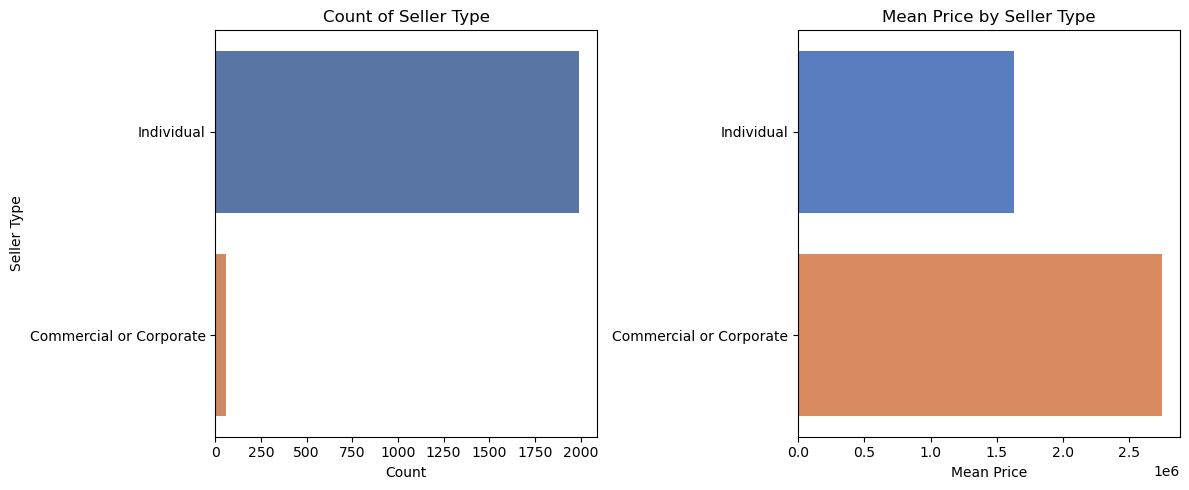

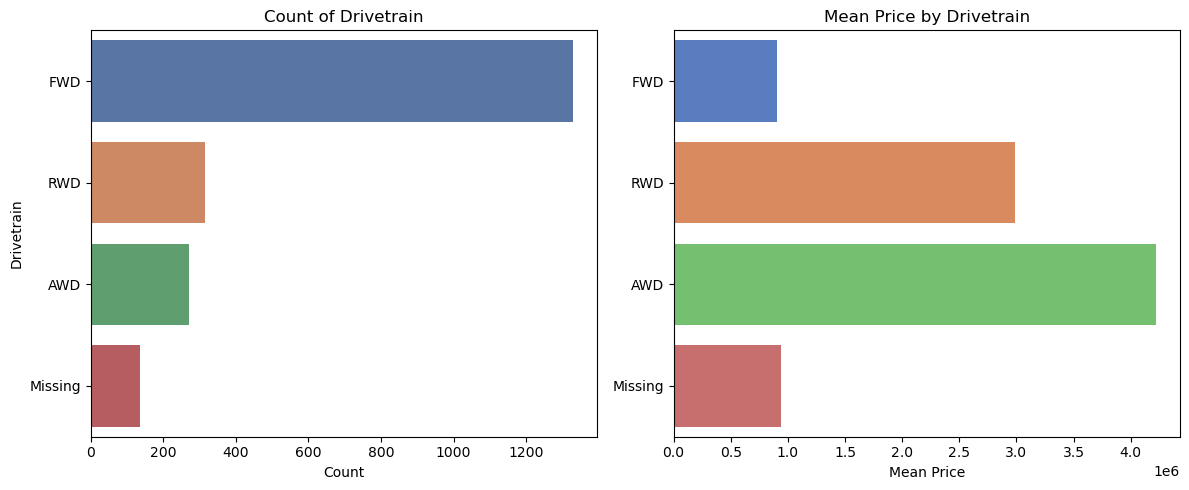

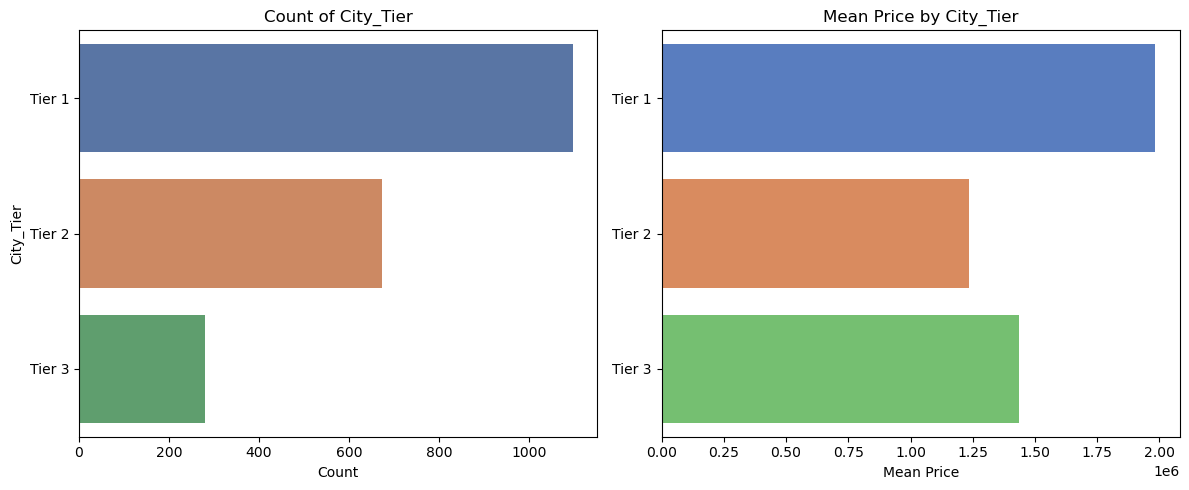

In [83]:
 for col in categorical_features:
        # Prepare data
        count = df[col].value_counts().head(20)
        mean_target = df.groupby(col)[target].mean().loc[count.index]

        # Create subplot
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Barplot: count
        sns.barplot(x=count.values, y=count.index.astype(str), ax=axes[0], palette='deep')
        axes[0].set_title(f'Count of {col}')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel(col)

        # Barplot: mean target
        sns.barplot(x=mean_target.values, y=mean_target.index.astype(str), ax=axes[1], palette='muted')
        axes[1].set_title(f'Mean {target} by {col}')
        axes[1].set_xlabel(f'Mean {target}')
        axes[1].set_ylabel('')

        plt.tight_layout()
        plt.show()

## Step 6: Feature Engneering (Numerical Feature)

### 6.1 Function Transformation
We apply a function transformation to reduce skewness in our numeric data and make the distribution normal, which often improves model performance and stability.

#### Distribution Before Transformation

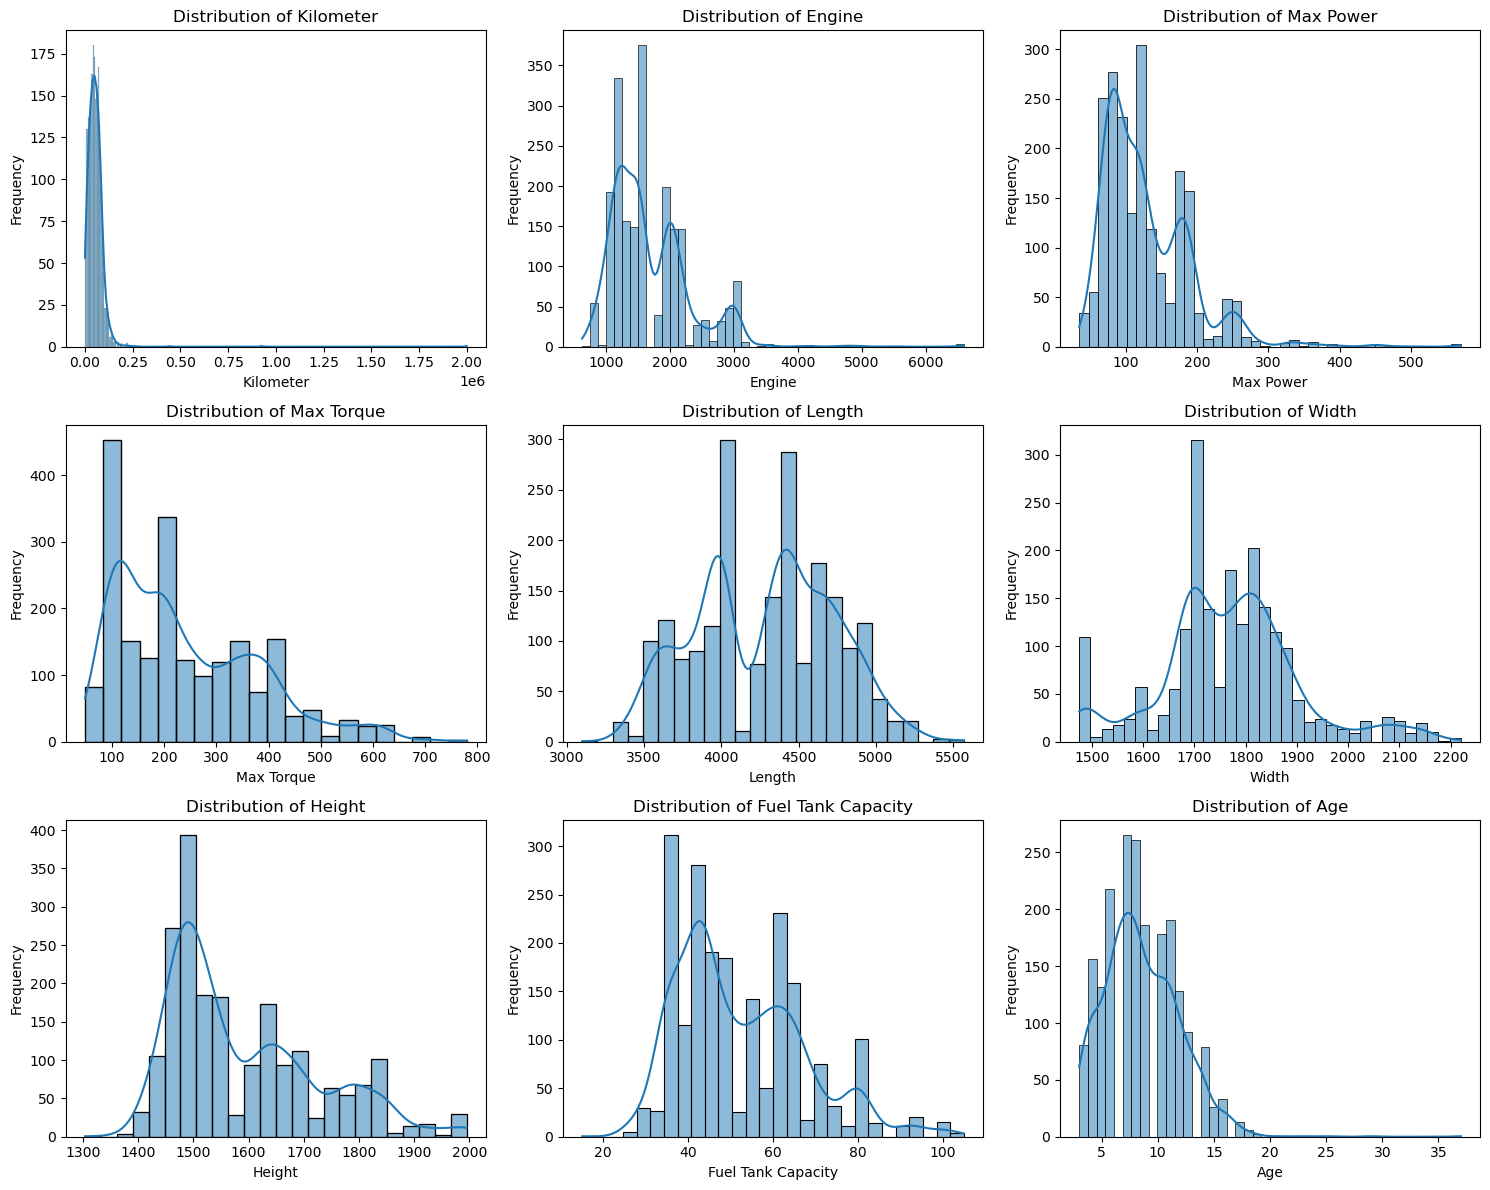

In [87]:
numerical_features = df.select_dtypes(include='number').columns
numerical_features = numerical_features.drop('Price')
numerical_features = numerical_features.drop('Seating Capacity')
numerical_features = numerical_features.drop('Fuel_Tank_Capacity_Missing')
n_cols = 3
n_rows = (len(numerical_features) + n_cols - 1) // n_cols

# Create subplots
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(numerical_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [88]:
# Log transformation for heavily skewed features
df['Kilometer'] = np.log1p(df['Kilometer'])
df['Engine'] = np.log1p(df['Engine'])
df['Max Power'] = np.log1p(df['Max Power'])
df['Max Torque'] = np.log1p(df['Max Torque'])
df['Age'] = np.log1p(df['Age'])

# Square root transformation for mildly skewed
df['Fuel Tank Capacity'] = np.sqrt(df['Fuel Tank Capacity'])

### 6.2 Scaling Numerical Features
We scale the features to have a mean of 0 and a standard deviation of 1, which helps models learn more effectively.

In [90]:
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

#### 6.3 Distribution and Outliers After Transformation and Scaling

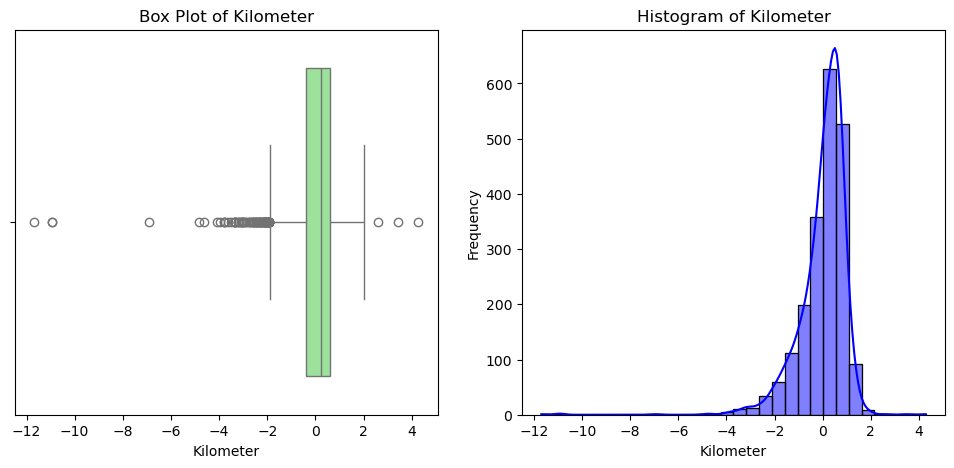

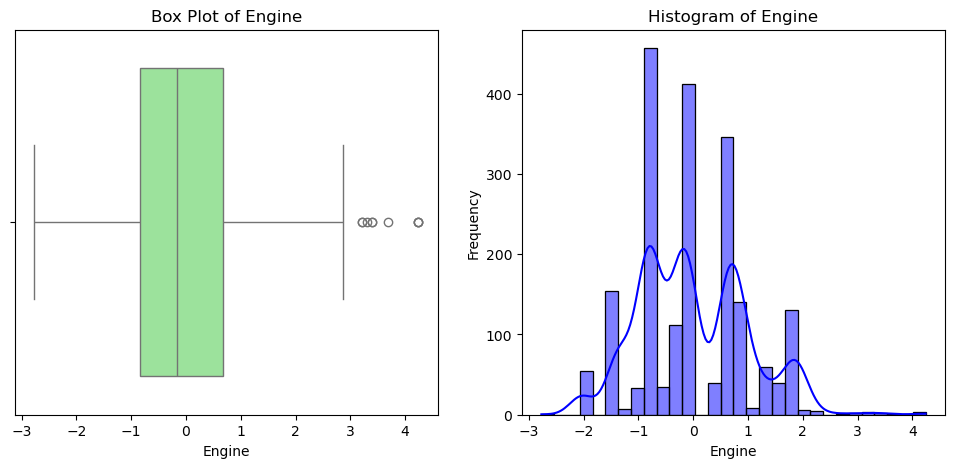

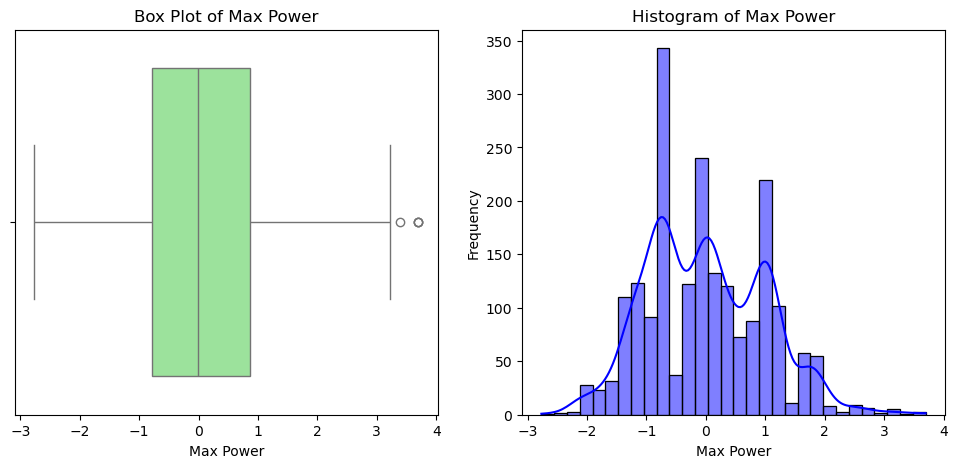

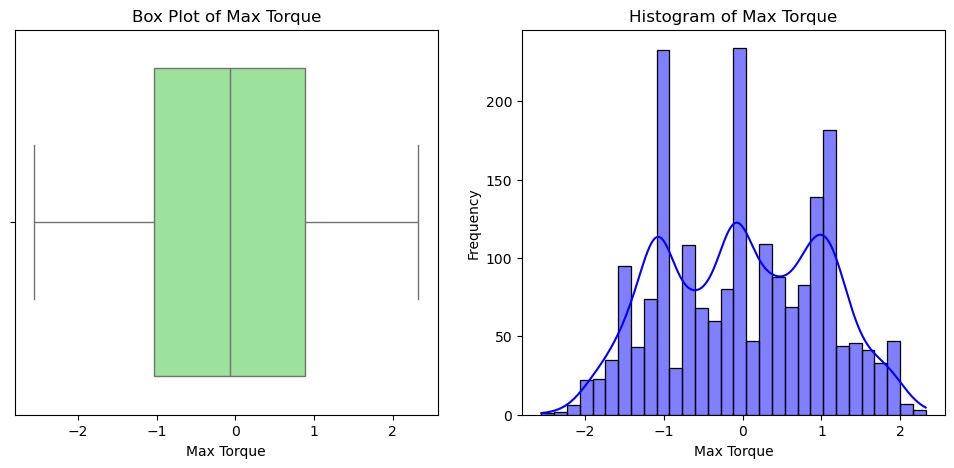

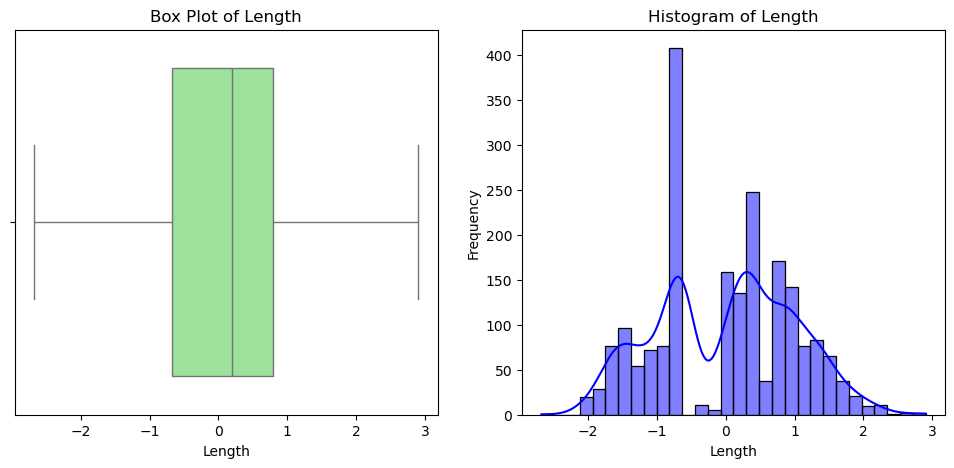

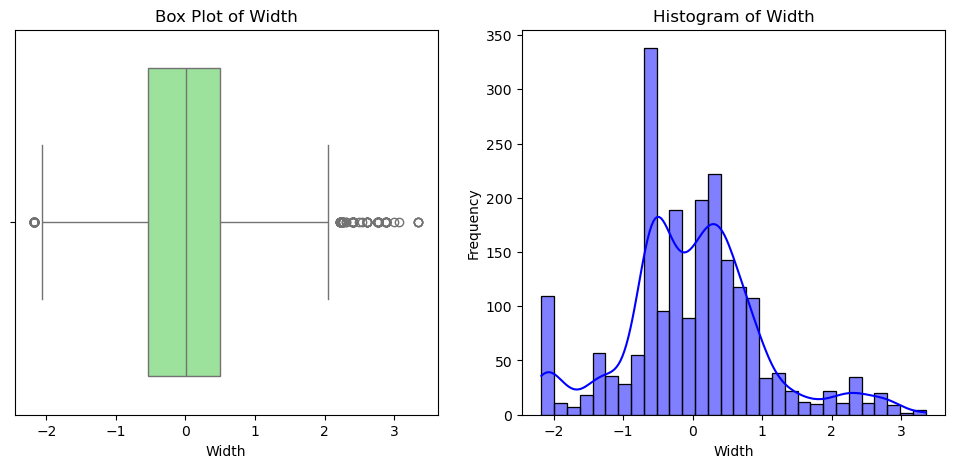

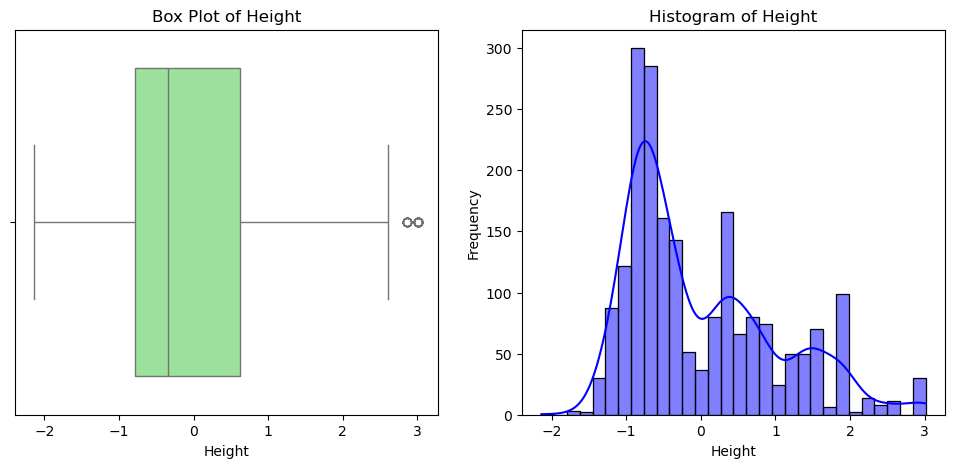

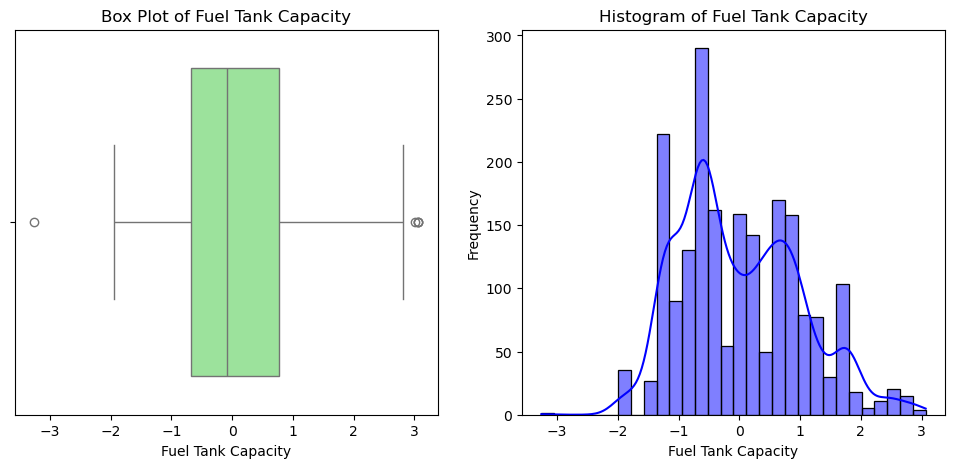

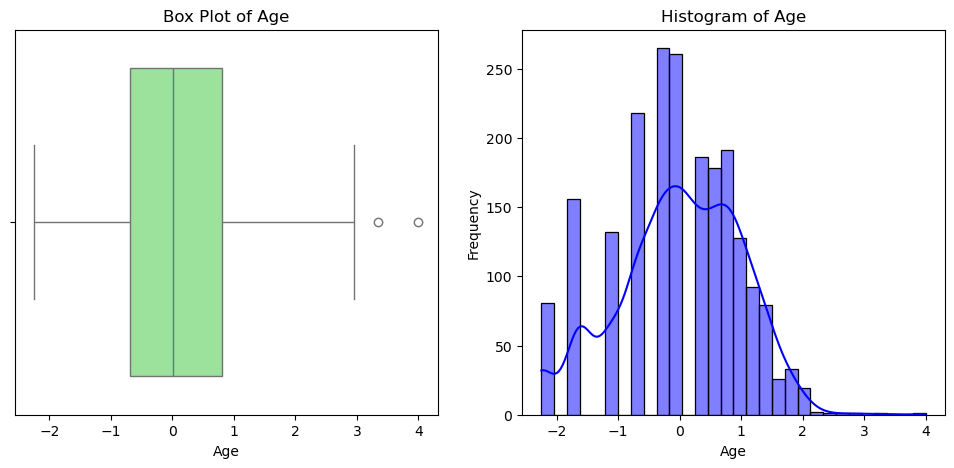

In [92]:
for i, col in enumerate(numerical_features, 1):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # Histogram
    sns.histplot(data=df, x=col, bins=30, kde=True, ax=axes[1], color='blue')
    axes[1].set_title(f'Histogram of {col}')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Frequency')
    
    # Box Plot
    sns.boxplot(data=df, x=col, ax=axes[0], color='lightgreen')
    axes[0].set_title(f'Box Plot of {col}')
    axes[0].set_xlabel(col)    
plt.show()

## Step 7: Feature Engineering (Encoding and Checking Correlation)

### 7.1 Encoding Categorical Variable

In [95]:
# 1. Ordinal encode City_Tier
city_tier_map = {'Tier 1': 1, 'Tier 2': 2, 'Tier 3': 3}
df['City_Tier'] = df['City_Tier'].map(city_tier_map)

# 2. Define categorical columns (excluding City_Tier)
label_cols = ['Make', 'Fuel Type', 'Transmission', 'Color', 'Owner', 'Seller Type', 'Drivetrain']

# 3. Apply Label Encoding
le_dict = {}  # To store encoders if you need to inverse_transform later

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  # Save encoder


In [96]:
df.head()

,Make,Price,Kilometer,Fuel Type,Transmission,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,Fuel_Tank_Capacity_Missing,City_Tier,Age
0,3,505000,0.826082,2,1,5,1,0,-0.832594,-0.677160,-1.130707,1,-0.665193,-0.656223,-0.638536,5.0,-1.232208,0,1,0.002632
1,8,450000,0.660939,0,1,10,2,1,-0.710982,-1.051181,-0.158138,1,-0.653891,-0.544988,-0.265845,5.0,-0.671695,0,2,0.800957
2,4,220000,0.536874,2,1,6,1,1,-0.835078,-0.900171,-1.071436,1,-1.580694,-1.286552,-0.303115,5.0,-1.232208,0,2,1.420187
3,16,799000,-0.101456,2,1,8,1,1,-0.835078,-0.814032,-1.067751,1,-0.653891,-0.174206,-0.601267,5.0,-1.066749,0,3,-0.694773
4,16,1950000,0.569227,0,1,5,1,1,1.225690,0.555027,0.878896,3,1.018875,0.456123,1.523070,7.0,0.256891,0,1,-0.324219


### 7.2 Visualizing Strong Correlations

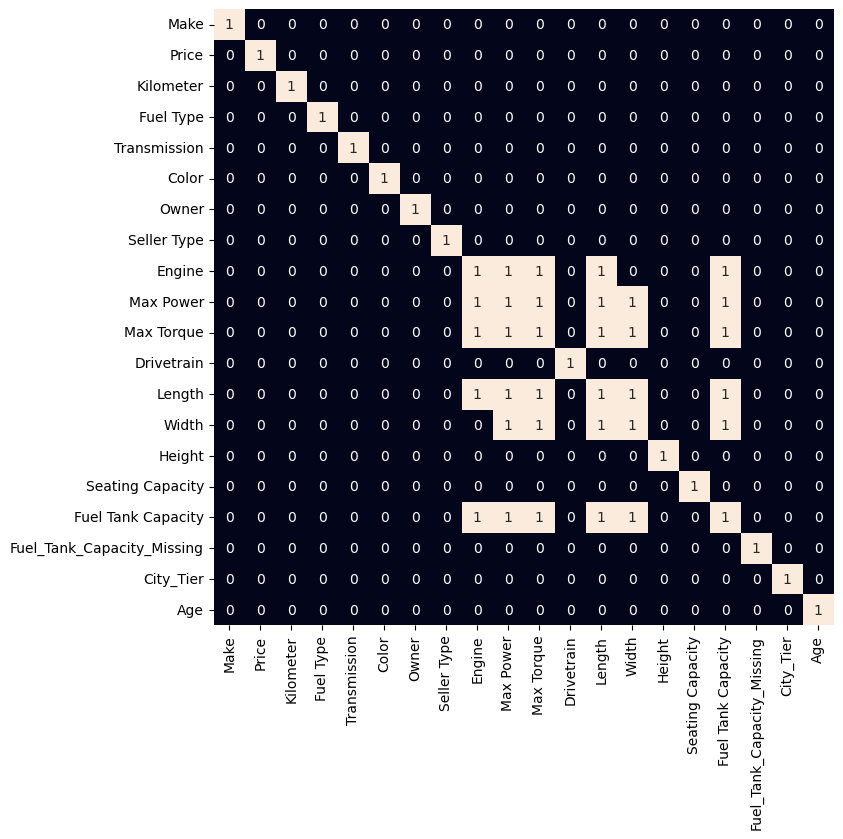

In [98]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.select_dtypes(include=np.number).corr() > 0.8, 
            annot=True, 
            cbar=False) 
plt.show()

### 7.3 Variance Inflation Factor (VIF)
VIF tells you how much the variance of a feature is inflated due to multicollinearity with other features.

In [100]:
# Select only numerical and encoded features (exclude target variable)
X = df.drop(columns=['Price'])  # replace with your target variable name

# Optional: drop any non-numeric columns (just in case)
X = X.select_dtypes(include=[float, int, 'int64', 'float64'])

# Add intercept term
X = add_constant(X)

# Compute VIF
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Drop constant row if you want
vif = vif[vif["Feature"] != "const"]

print(vif.sort_values(by="VIF", ascending=False))

                       Feature        VIF
10                  Max Torque  31.758130
9                    Max Power  29.615182
8                       Engine   9.303846
12                      Length   7.443035
3                    Fuel Type   6.615081
16          Fuel Tank Capacity   5.135745
13                       Width   4.571623
14                      Height   3.052343
15            Seating Capacity   2.649708
19                         Age   1.999522
4                 Transmission   1.892550
2                    Kilometer   1.866255
1                         Make   1.201689
11                  Drivetrain   1.193543
17  Fuel_Tank_Capacity_Missing   1.100758
18                   City_Tier   1.072483
5                        Color   1.055347
6                        Owner   1.039816
7                  Seller Type   1.019658


### 7.4 Dropping Strongly Collinear Features

In [102]:
# Drop Max Torque
df.drop(columns=['Max Torque'], inplace=True)
df.drop(columns=['Max Power'], inplace=True)
# Combine Length and Width into a new feature called 'Area'
df['Area'] = df['Length'] * df['Width']

# Optionally drop the original Length and Width columns
df.drop(columns=['Length', 'Width'], inplace=True)

### 7.5 Rechecking VIF

In [104]:
# Select only numerical and encoded features (exclude target variable)
X = df.drop(columns=['Price'])  # replace with your target variable name

# Optional: drop any non-numeric columns (just in case)
X = X.select_dtypes(include=[float, int, 'int64', 'float64'])

# Add intercept term
X = add_constant(X)

# Compute VIF
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Drop constant row if you want
vif = vif[vif["Feature"] != "const"]

print(vif.sort_values(by="VIF", ascending=False))

                       Feature       VIF
12          Fuel Tank Capacity  3.784871
8                       Engine  3.761787
10                      Height  2.485393
11            Seating Capacity  2.274566
15                         Age  1.915163
2                    Kilometer  1.864561
4                 Transmission  1.806565
3                    Fuel Type  1.566372
9                   Drivetrain  1.176543
16                        Area  1.131740
1                         Make  1.112975
14                   City_Tier  1.067311
13  Fuel_Tank_Capacity_Missing  1.066937
5                        Color  1.051033
6                        Owner  1.035501
7                  Seller Type  1.017883


### 7.6 Rechecking Correlation Matrix

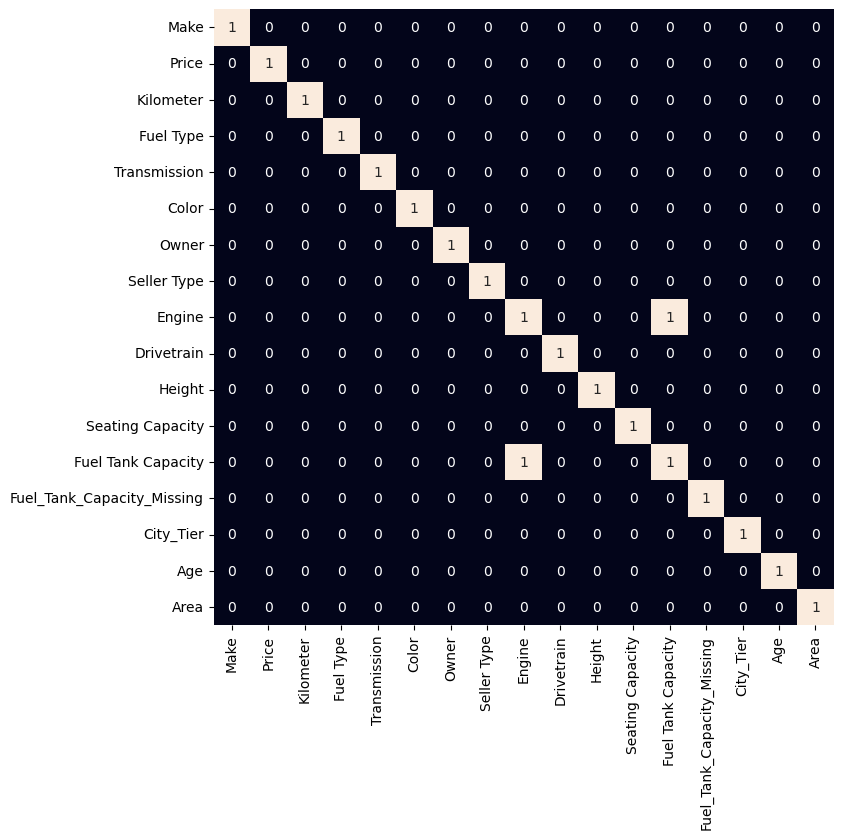

In [106]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.select_dtypes(include=np.number).corr() > 0.8, 
            annot=True, 
            cbar=False) 
plt.show()

## Step 6: Model Training

In [108]:
df.head()

,Make,Price,Kilometer,Fuel Type,Transmission,Color,Owner,Seller Type,Engine,Drivetrain,Height,Seating Capacity,Fuel Tank Capacity,Fuel_Tank_Capacity_Missing,City_Tier,Age,Area
0,3,505000,0.826082,2,1,5,1,0,-0.832594,1,-0.638536,5.0,-1.232208,0,1,0.002632,0.436515
1,8,450000,0.660939,0,1,10,2,1,-0.710982,1,-0.265845,5.0,-0.671695,0,2,0.800957,0.356363
2,4,220000,0.536874,2,1,6,1,1,-0.835078,1,-0.303115,5.0,-1.232208,0,2,1.420187,2.033645
3,16,799000,-0.101456,2,1,8,1,1,-0.835078,1,-0.601267,5.0,-1.066749,0,3,-0.694773,0.113912
4,16,1950000,0.569227,0,1,5,1,1,1.225690,3,1.523070,7.0,0.256891,0,1,-0.324219,0.464733


### 6.1 Separating the features and target variables and split them into training and the testing data.

In [110]:
X = df.drop(columns=['Price'])  # Features
y = np.log(df['Price'])                 # Target. I am using log as without log model was overfitting.

# 80-20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=59
)
X_train.shape, X_test.shape 

((1641, 16), (411, 16))

### 6.2 Model Training

In [112]:
# Target variable is 'Price'
# 1. Define and train the model
xgb = XGBRegressor(random_state=79, n_jobs=-1)
xgb.fit(X_train, y_train)

# 2. Predictions
train_preds = xgb.predict(X_train)
test_preds = xgb.predict(X_test)

# 3. Evaluation function
def evaluate(y_true, y_pred):
    return {
        'R2 Score': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }

# 4. Evaluate both sets
train_metrics = evaluate(y_train, train_preds)
test_metrics = evaluate(y_test, test_preds)

# 5. Display results
print("🔹 Training Metrics:")
for k, v in train_metrics.items():
    print(f"{k}: {v:.4f}")

print("\n🔹 Test Metrics:")
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")

🔹 Training Metrics:
R2 Score: 0.9984
MAE: 0.0271
RMSE: 0.0389
MAPE: 0.0020

🔹 Test Metrics:
R2 Score: 0.9468
MAE: 0.1533
RMSE: 0.2326
MAPE: 0.0111


### 6.3 Convert Back to Actual Prices

In [114]:
y_test_actual = np.exp(y_test)
y_pred_actual = np.exp(test_preds)

mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(np.mean((y_test_actual - y_pred_actual) ** 2))
r2 = r2_score(y_test_actual, y_pred_actual)
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual)

# Display results
print("🔹 Test Metrics (In Original Price Scale):")
print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")
print(f"MAPE: {mape:.4f}")


🔹 Test Metrics (In Original Price Scale):
R2 Score: 0.8296
MAE: 298,202
RMSE: 1,002,742
MAPE: 0.1579


### 6.4 RandomizedSearchCV (Choosing Best XGBModel)

In [116]:
# Step 1: Define model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Step 2: Define parameter grid
param_dist = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],   # L1 regularization
    'reg_lambda': [0.1, 1, 10]  # L2 regularization
}

# Step 3: Run randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    verbose=1,
    random_state=42,
    scoring='r2',
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Step 4: Get best model
best_model = random_search.best_estimator_

# Step 5: Evaluate on training and test data
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

def print_metrics(y_true, y_pred, label=''):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"🔹 {label} Metrics:")
    print(f"R2 Score: {r2:.4f}")
    print(f"MAE: {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"MAPE: {mape:.4f}\n")

print_metrics(y_train, y_train_pred, 'Training')
print_metrics(y_test, y_test_pred, 'Test')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
🔹 Training Metrics:
R2 Score: 0.9803
MAE: 0.11
RMSE: 0.13
MAPE: 0.0077

🔹 Test Metrics:
R2 Score: 0.9553
MAE: 0.14
RMSE: 0.21
MAPE: 0.0106



### 6.5 Final evaluation metrics (after RandomizedSearchCV)

In [118]:
# Predict log(price) using the best model
y_pred_log = best_model.predict(X_test)

# Convert both prediction and actual target back to original scale
y_pred = np.exp(y_pred_log)
y_actual = np.exp(y_test)

# Compute metrics in original scale
r2 = r2_score(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mape = np.mean(np.abs((y_actual - y_pred) / y_actual))

# Print metrics
print(f"🔹 Final Test Metrics (after RandomizedSearchCV, in original price scale):")
print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")
print(f"MAPE: {mape:.4f}")

🔹 Final Test Metrics (after RandomizedSearchCV, in original price scale):
R2 Score: 0.8701
MAE: 277,390
RMSE: 875,598
MAPE: 0.1537


### 6.6 Actual and Predicted price (after using the best model)

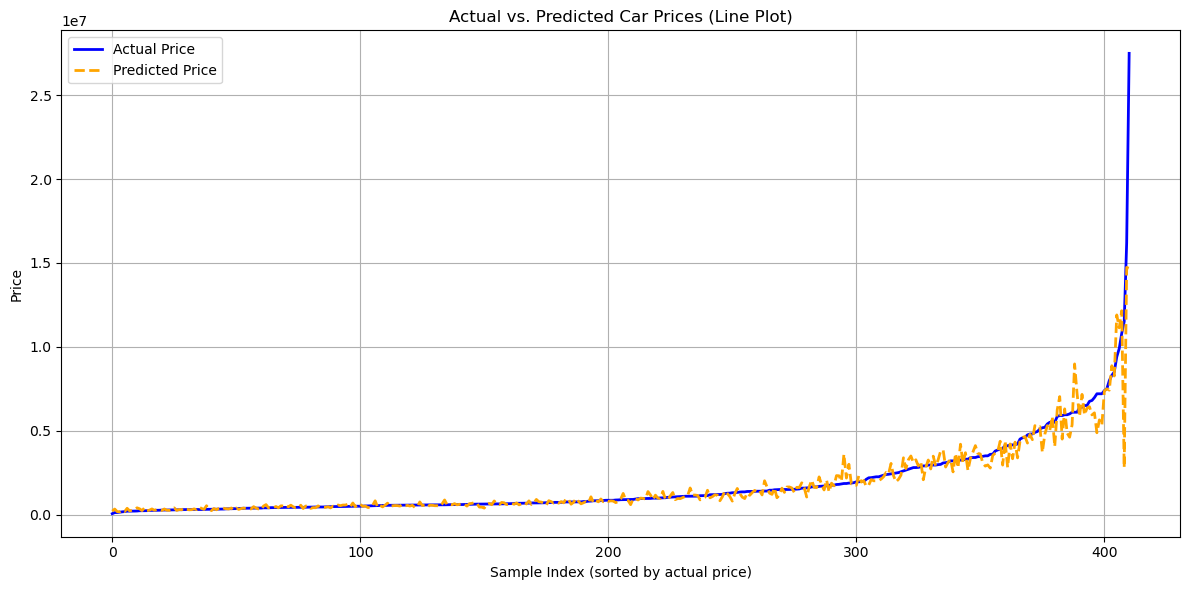

In [120]:
y_pred_log = best_model.predict(X_test)

# Convert both prediction and actual target back to original scale
y_pred = np.exp(y_pred_log)
y_actual = np.exp(y_test)

# Sort by actual price for a cleaner plot (optional)
comparison_df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})
comparison_df = comparison_df.sort_values(by='Actual').reset_index(drop=True)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Actual'], label='Actual Price', color='blue', linewidth=2)
plt.plot(comparison_df['Predicted'], label='Predicted Price', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Sample Index (sorted by actual price)')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Car Prices (Line Plot)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()